## Provide list of paths for edits and run trials -> (maybe analyze results and add to CSV)

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [35]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn, combine_results
from utils.analysis_utils import combine_results
from edit_knn import main as edit

In [36]:
# Obtain timestamp
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')

In [37]:
# Define constants, paths
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
class_list_path = 'metadata/cinic-10/class_names.txt'
# key_image_id = 'dog-train-n02114712_211'
target_class_name = 'dog'

analyze_in_edit = True
# paths_dir = os.path.join('paths', 'edits', key_image_id)
paths_dir = os.path.join('paths', 'edits', target_class_name, '0113_120339')

key_image_paths = read_lists(os.path.join(paths_dir, 'key_images.txt'))
value_image_paths = read_lists(os.path.join(paths_dir, 'value_images.txt'))
n_trials = len(value_image_paths)
assert len(key_image_paths) == n_trials

print("First key image path: {}".format(key_image_paths[0]))
print("First value image path: {}".format(value_image_paths[0]))

First key image path: data/cinic-10-imagenet/train/dog/n02118333_7249.png
First value image path: saved/segmentations/dog/dog-train-n02118333_7249/modified_images/slic_masked_1.png


In [38]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)
target_class_idx = class_idx_dict[target_class_name]

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [39]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Create log and save paths

In [40]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
if os.path.exists(save_trials_path):
    # os.remove(save_trials_path)
    print("Path {} already exists. Aborting.".format(save_trials_path))
else:
    progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(save_trials_path))
    print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/trial_paths.txt
Printing progress reports to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/progress_report.txt


### Ensure all paths for keys and values exist

In [41]:
non_existent_key_paths = []
non_existent_value_paths = []
for key_path, value_path in zip(key_image_paths, value_image_paths):
    if not os.path.exists(key_path):
        non_existent_key_paths.append(key_path)
    if not os.path.exists(value_path):
        non_existent_value_paths.append(value_path)

if len(non_existent_key_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))
    
if len(non_existent_value_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))

## Run edit for each modified image

(0113_160243) Starting Trial 1/2008...
Current run_id: 0113_160154/dog-train-n02118333_7249/slic_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02118333_7249.png
Value images: saved/segmentations/dog/dog-train-n02118333_7249/modified_images/slic_masked_1.png
Masks: None
Prepared data for editing
Performing pre-edit metric & KNN calculations on validation set.


100%|██████████████████████████████████████████| 274/274 [07:17<00:00,  1.60s/it]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.06783458590507507 0.005938022397458553
L2 norm of weight change: 0.2369346022605896
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.56it/s]


Post-edit metrics: {'TP': array([6019, 5469, 5072, 3700, 4472, 3381, 5759, 4516, 5122, 4448]), 'TN': array([60659, 60975, 59849, 60042, 59607, 60934, 60747, 62438, 61135,
       61572]), 'FPs': array([2341, 2025, 3151, 2958, 3393, 2066, 2253,  562, 1865, 1428]), 'FNs': array([ 981, 1531, 1928, 3300, 2528, 3619, 1241, 2484, 1878, 2552]), 'accuracy': 0.6851142857142857, 'per_class_accuracy': array([0.95254286, 0.9492    , 0.92744286, 0.9106    , 0.91541429,
       0.91878571, 0.95008571, 0.95648571, 0.94652857, 0.94314286]), 'per_class_accuracy_mean': 0.9370228571428573, 'precision': array([0.71997608, 0.72978383, 0.61680652, 0.55572244, 0.56859504,
       0.62070865, 0.7187968 , 0.88932651, 0.73307571, 0.75697754]), 'precision_mean': 0.6909769108440533, 'recall': array([0.85985714, 0.78128571, 0.72457143, 0.52857143, 0.63885714,
       0.483     , 0.82271429, 0.64514286, 0.73171429, 0.63542857]), 'recall_mean': 0.6851142857142858, 'f1': array([0.78372396, 0.7546571 , 0.66636011, 0.54180

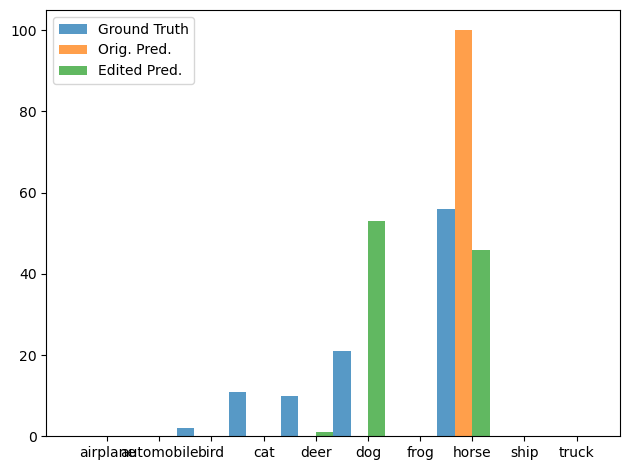

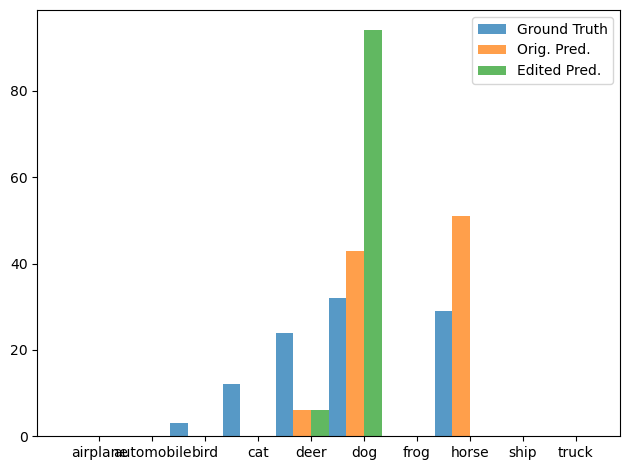

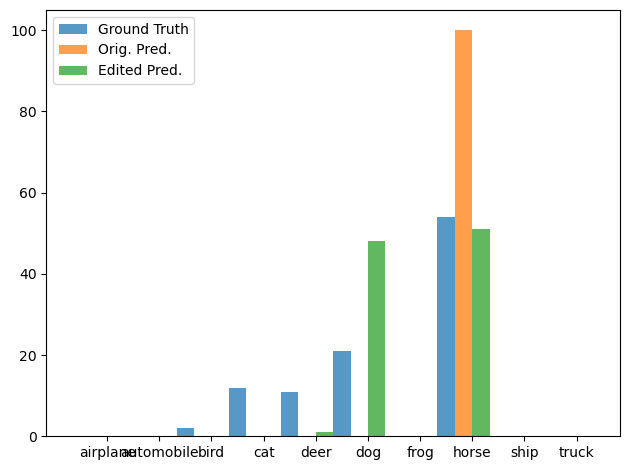

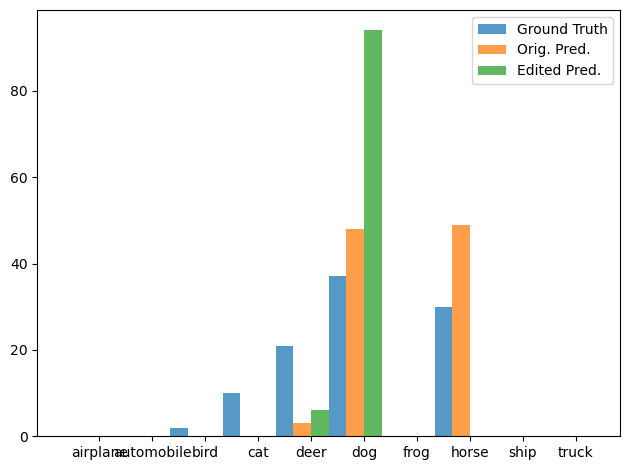

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1/models
Finished trial 1/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1
(0113_161118) Starting Trial 2/2008...
Current run_id: 0113_160154/dog-train-n02112706_413/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112706_413.png
Value images: saved/segmentations/dog/dog-train-n02112706_413/modi

100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.81it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0154, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.13256171345710754 0.015396649949252605
L2 norm of weight change: 0.34892717003822327
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:18<00:00, 14.66it/s]


Post-edit metrics: {'TP': array([6122, 5452, 5410, 4294, 2742, 3348, 5623, 5095, 4666, 4634]), 'TN': array([60217, 60974, 58475, 58373, 62396, 60922, 61022, 61884, 61824,
       61299]), 'FPs': array([2783, 2026, 4525, 4627,  604, 2078, 1978, 1116, 1176, 1701]), 'FNs': array([ 878, 1548, 1590, 2706, 4258, 3652, 1377, 1905, 2334, 2366]), 'accuracy': 0.6769428571428572, 'per_class_accuracy': array([0.9477    , 0.94894286, 0.91264286, 0.89524286, 0.93054286,
       0.91814286, 0.95207143, 0.95684286, 0.94985714, 0.9419    ]), 'per_class_accuracy_mean': 0.9353885714285715, 'precision': array([0.68747894, 0.72907194, 0.54453951, 0.48133617, 0.81948595,
       0.61702912, 0.73977108, 0.82031879, 0.79869908, 0.73149171]), 'precision_mean': 0.6969222301449255, 'recall': array([0.87457143, 0.77885714, 0.77285714, 0.61342857, 0.39171429,
       0.47828571, 0.80328571, 0.72785714, 0.66657143, 0.662     ]), 'recall_mean': 0.6769428571428572, 'f1': array([0.76982081, 0.7531427 , 0.63891349, 0.53941

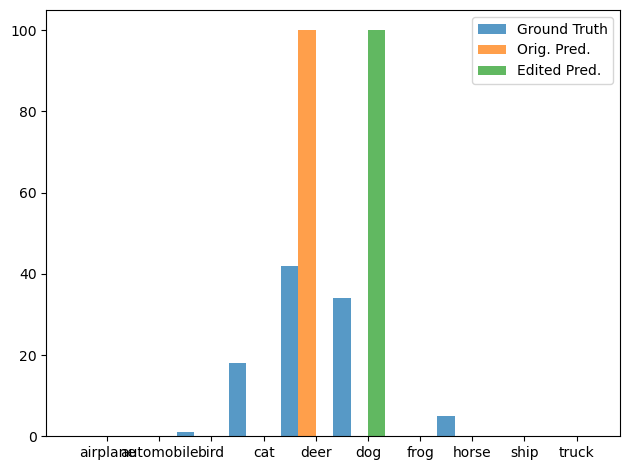

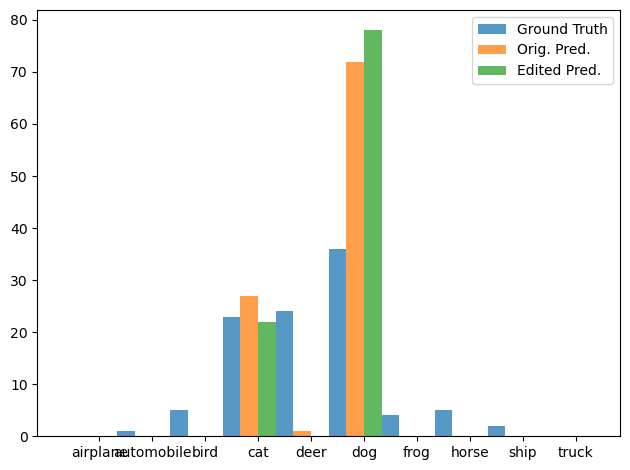

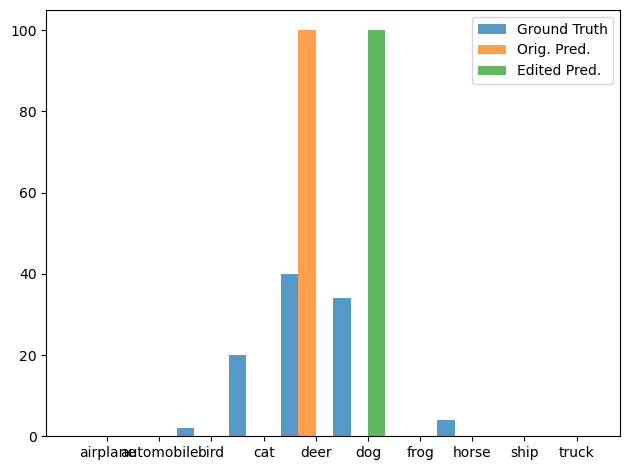

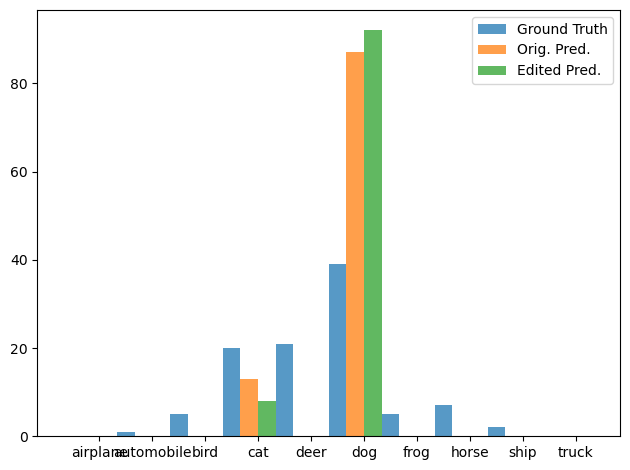

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0/models
Finished trial 2/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0
(0113_161256) Starting Trial 3/2008...
Current run_id: 0113_160154/dog-train-n02112706_413/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112706_413.png
Value images: saved/segmentations/dog/dog-train-n02112706_413/m

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.04it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.1898515522480011 0.003862569108605385
L2 norm of weight change: 0.6270527839660645
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 24.64it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5971, 5672, 5147, 3669,    0, 4893, 5180, 4672, 4557, 4360]), 'TN': array([60874, 60455, 59768, 60090, 63000, 51971, 62089, 62300, 61907,
       61667]), 'FPs': array([ 2126,  2545,  3232,  2910,     0, 11029,   911,   700,  1093,
        1333]), 'FNs': array([1029, 1328, 1853, 3331, 7000, 2107, 1820, 2328, 2443, 2640]), 'accuracy': 0.6303, 'per_class_accuracy': array([0.95492857, 0.94467143, 0.92735714, 0.91084286, 0.9       ,
       0.81234286, 0.96098571, 0.95674286, 0.94948571, 0.94324286]), 'per_class_accuracy_mean': 0.92606, 'precision': array([0.73743362, 0.69027626, 0.61427378, 0.55768354, 0.        ,
       0.30731064, 0.85043507, 0.86969471, 0.80654867, 0.7658528 ]), 'precision_mean': 0.6199509087230727, 'recall': array([0.853     , 0.81028571, 0.73528571, 0.52414286, 0.        ,
       0.699     , 0.74      , 0.66742857, 0.651     , 0.62285714]), 'recall_mean': 0.6302999999999999, 'f1': array([0.79101808, 0.74548203, 0.66935431, 0.54039325, 0

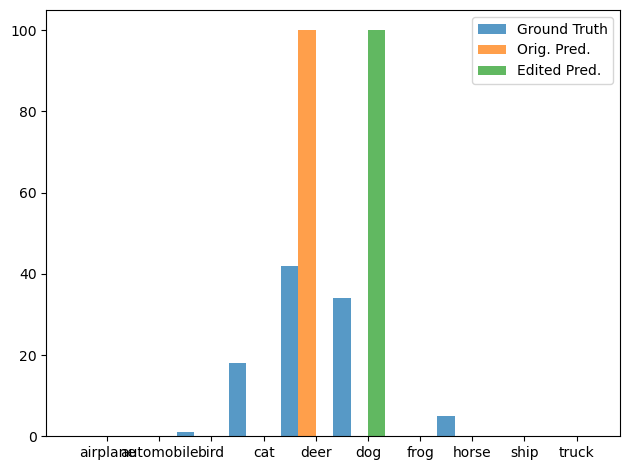

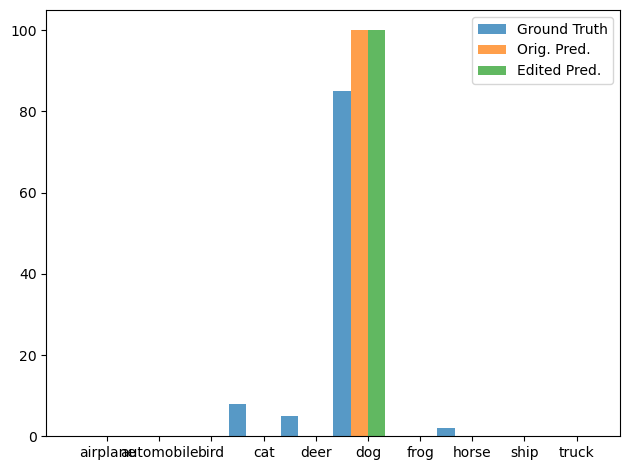

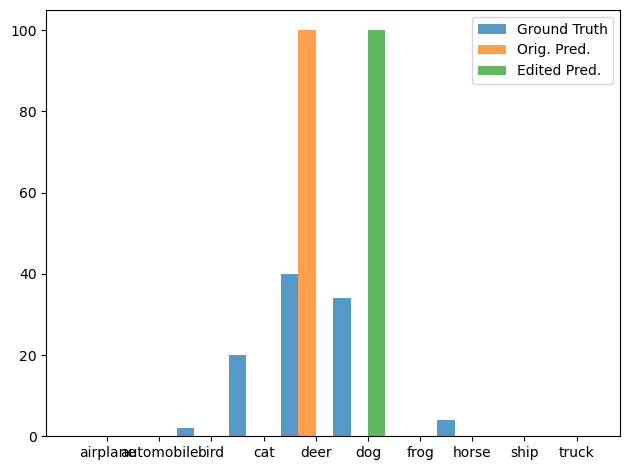

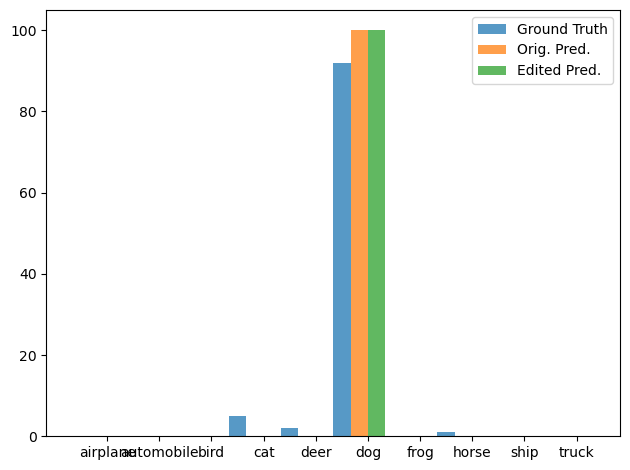

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0/models
Finished trial 3/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0
(0113_161427) Starting Trial 4/2008...
Current run_id: 0113_160154/dog-train-n02112706_413/watershed_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112706_413.png
Value images: saved/segmentations/dog/dog-train-n02112706_413/modified_

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.82it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0091, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.14813995361328125 0.009126828983426094
L2 norm of weight change: 0.41893187165260315
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 21.87it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6055, 5545, 5380, 4019,    0, 4183, 5453, 5026, 4694, 4512]), 'TN': array([60509, 60790, 58817, 59307, 63000, 55646, 61517, 61982, 61810,
       61489]), 'FPs': array([2491, 2210, 4183, 3693,    0, 7354, 1483, 1018, 1190, 1511]), 'FNs': array([ 945, 1455, 1620, 2981, 7000, 2817, 1547, 1974, 2306, 2488]), 'accuracy': 0.6409571428571429, 'per_class_accuracy': array([0.95091429, 0.94764286, 0.9171    , 0.90465714, 0.9       ,
       0.8547    , 0.95671429, 0.95725714, 0.95005714, 0.94287143]), 'per_class_accuracy_mean': 0.9281914285714287, 'precision': array([0.70851861, 0.71502257, 0.56258496, 0.52113589, 0.        ,
       0.36257259, 0.786188  , 0.8315685 , 0.79775663, 0.74912834]), 'precision_mean': 0.6034476090603647, 'recall': array([0.865     , 0.79214286, 0.76857143, 0.57414286, 0.        ,
       0.59757143, 0.779     , 0.718     , 0.67057143, 0.64457143]), 'recall_mean': 0.6409571428571429, 'f1': array([0.77897852, 0.75160962, 0.64964077, 0.54635

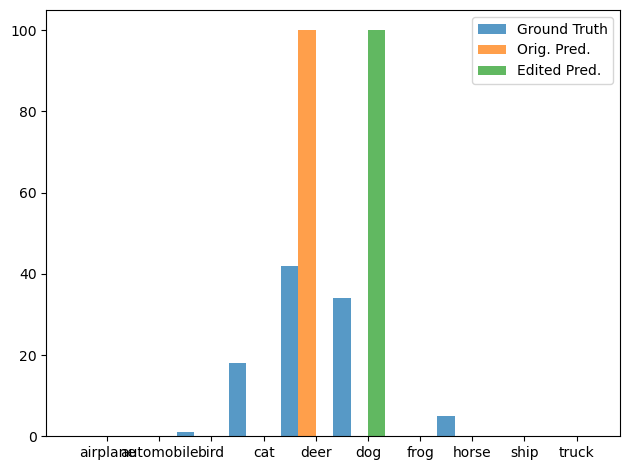

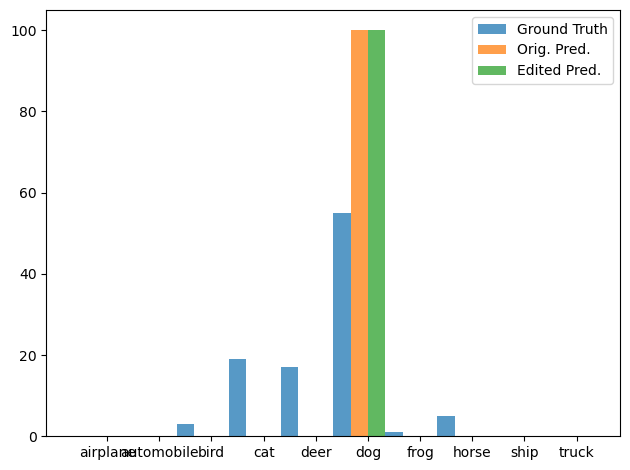

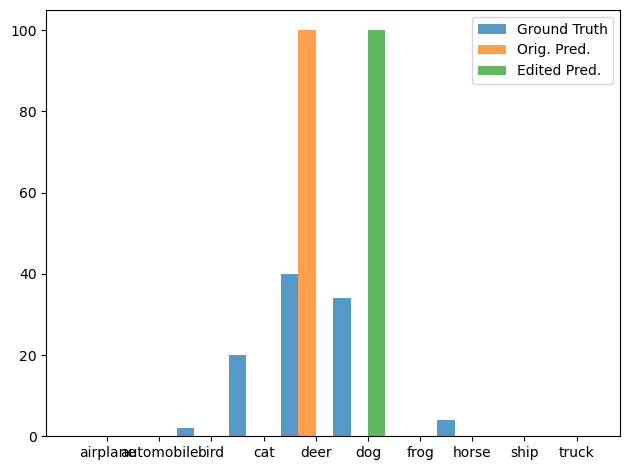

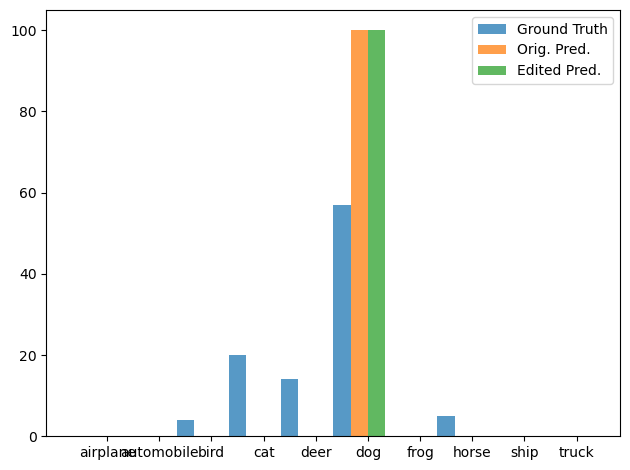

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2/models
Finished trial 4/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2
(0113_161554) Starting Trial 5/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentations/dog/dog-tr

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.11it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.14329561591148376 0.011321231722831726
L2 norm of weight change: 0.3543589115142822
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.74it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6060, 5498, 5292, 4088,    0, 4091, 5514, 5069, 4786, 4567]), 'TN': array([60468, 60898, 59227, 59088, 63000, 55808, 61436, 61924, 61698,
       61418]), 'FPs': array([2532, 2102, 3773, 3912,    0, 7192, 1564, 1076, 1302, 1582]), 'FNs': array([ 940, 1502, 1708, 2912, 7000, 2909, 1486, 1931, 2214, 2433]), 'accuracy': 0.6423571428571428, 'per_class_accuracy': array([0.9504    , 0.94851429, 0.9217    , 0.90251429, 0.9       ,
       0.8557    , 0.95642857, 0.95704286, 0.94977143, 0.94264286]), 'per_class_accuracy_mean': 0.9284714285714285, 'precision': array([0.70530726, 0.72342105, 0.58378378, 0.511     , 0.        ,
       0.36258087, 0.77903363, 0.82489829, 0.78613666, 0.74272239]), 'precision_mean': 0.6018883945649526, 'recall': array([0.86571429, 0.78542857, 0.756     , 0.584     , 0.        ,
       0.58442857, 0.78771429, 0.72414286, 0.68371429, 0.65242857]), 'recall_mean': 0.6423571428571428, 'f1': array([0.7773217 , 0.75315068, 0.65882353, 0.54506

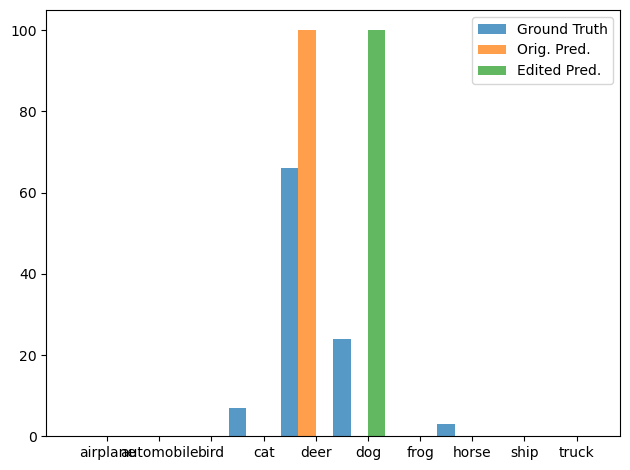

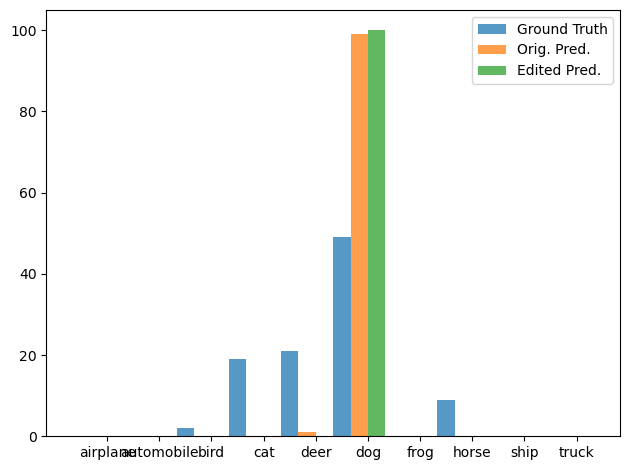

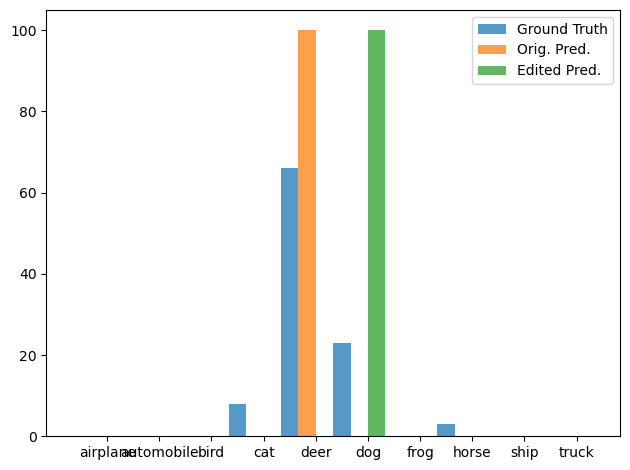

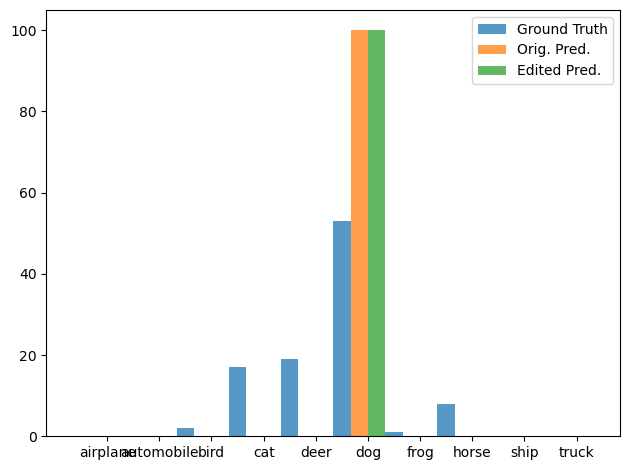

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0/models
Finished trial 5/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0
(0113_161718) Starting Trial 6/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentat

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.1777307391166687 0.028446832671761513
L2 norm of weight change: 0.4700171649456024
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 21.45it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6099, 5564, 5386, 3895,    0, 4124, 5407, 5313, 4575, 4551]), 'TN': array([60407, 60692, 58893, 59696, 63000, 55801, 61663, 61426, 61940,
       61396]), 'FPs': array([2593, 2308, 4107, 3304,    0, 7199, 1337, 1574, 1060, 1604]), 'FNs': array([ 901, 1436, 1614, 3105, 7000, 2876, 1593, 1687, 2425, 2449]), 'accuracy': 0.6416285714285714, 'per_class_accuracy': array([0.95008571, 0.94651429, 0.91827143, 0.90844286, 0.9       ,
       0.85607143, 0.95814286, 0.95341429, 0.95021429, 0.9421    ]), 'per_class_accuracy_mean': 0.9283257142857142, 'precision': array([0.70167971, 0.70680894, 0.56736543, 0.54104737, 0.        ,
       0.36421443, 0.8017497 , 0.77145346, 0.81188997, 0.73939886]), 'precision_mean': 0.600560787679741, 'recall': array([0.87128571, 0.79485714, 0.76942857, 0.55642857, 0.        ,
       0.58914286, 0.77242857, 0.759     , 0.65357143, 0.65014286]), 'recall_mean': 0.6416285714285714, 'f1': array([0.77733877, 0.74825175, 0.65312557, 0.548630

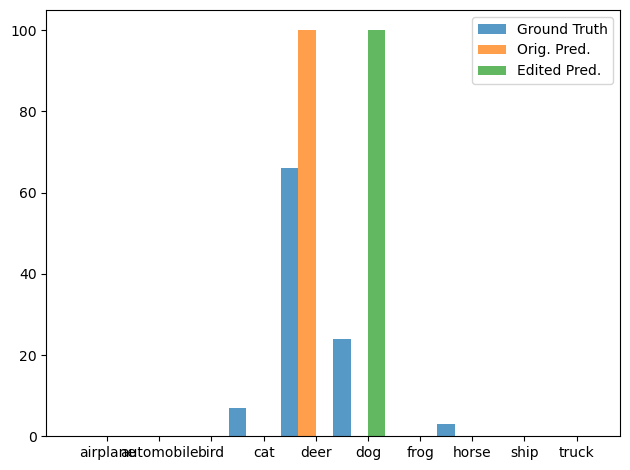

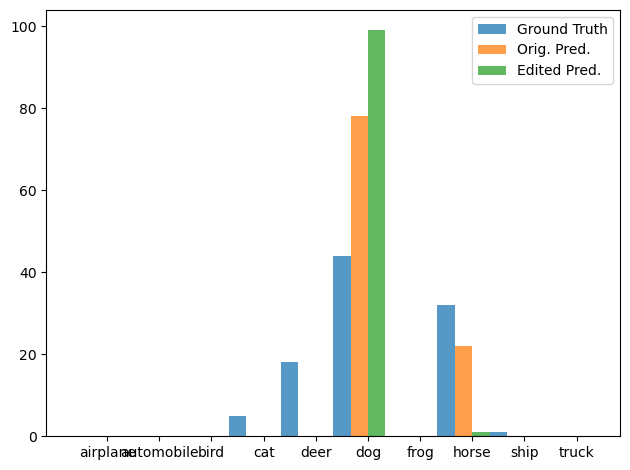

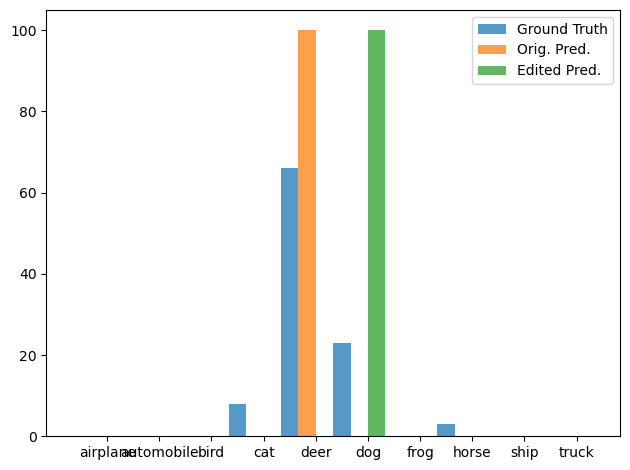

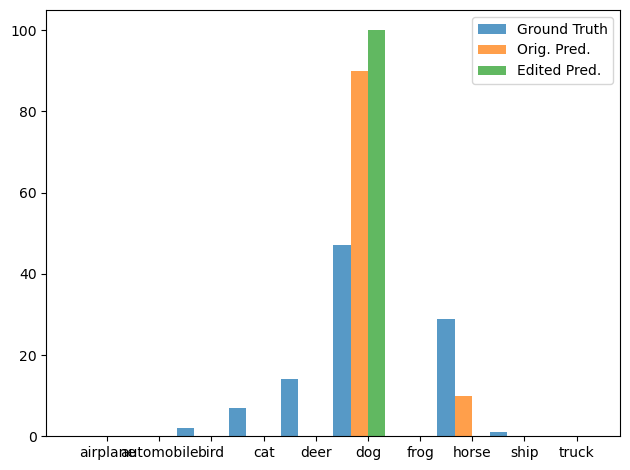

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1/models
Finished trial 6/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1
(0113_161844) Starting Trial 7/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.44it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0205, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.158466175198555 0.020535236224532127
L2 norm of weight change: 0.37811601161956787
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 27.26it/s]


Post-edit metrics: {'TP': array([6102, 5519, 5486, 3921,    4, 3932, 5548, 5131, 4717, 4533]), 'TN': array([60283, 60816, 58166, 59598, 63000, 56797, 61270, 61802, 61748,
       61413]), 'FPs': array([2717, 2184, 4834, 3402,    0, 6203, 1730, 1198, 1252, 1587]), 'FNs': array([ 898, 1481, 1514, 3079, 6996, 3068, 1452, 1869, 2283, 2467]), 'accuracy': 0.6413285714285715, 'per_class_accuracy': array([0.94835714, 0.94764286, 0.90931429, 0.90741429, 0.90005714,
       0.86755714, 0.95454286, 0.95618571, 0.9495    , 0.94208571]), 'per_class_accuracy_mean': 0.9282657142857141, 'precision': array([0.69191518, 0.7164741 , 0.53158915, 0.5354363 , 1.        ,
       0.38796251, 0.76229733, 0.81071259, 0.79024962, 0.74068627]), 'precision_mean': 0.6967323059001723, 'recall': array([8.71714286e-01, 7.88428571e-01, 7.83714286e-01, 5.60142857e-01,
       5.71428571e-04, 5.61714286e-01, 7.92571429e-01, 7.33000000e-01,
       6.73857143e-01, 6.47571429e-01]), 'recall_mean': 0.6413285714285714, 'f1': arr

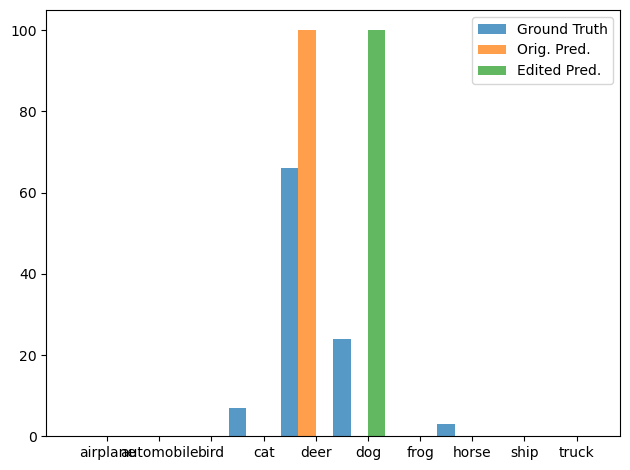

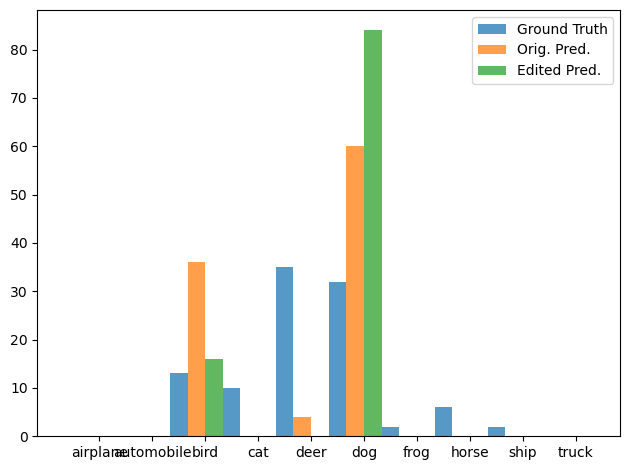

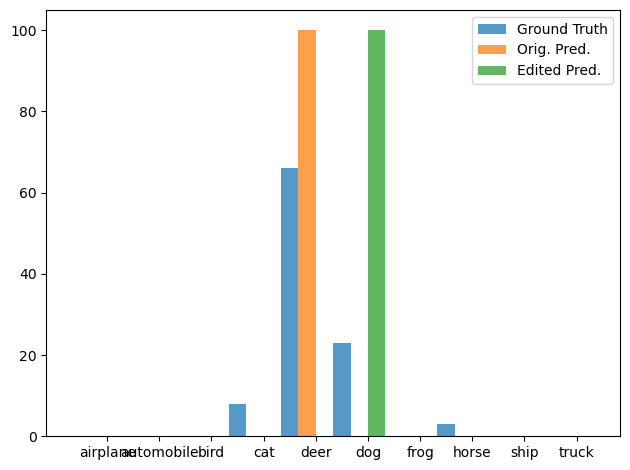

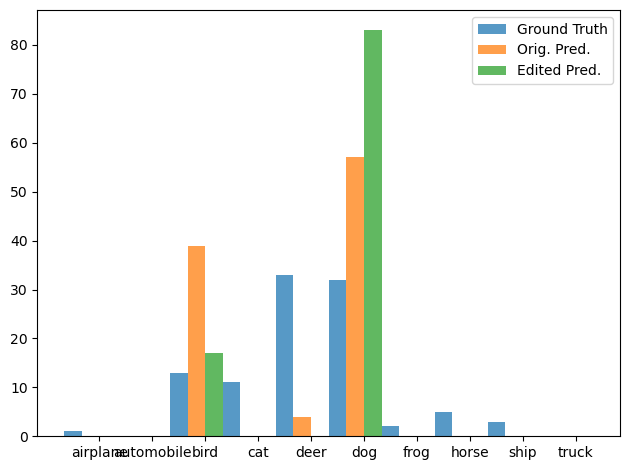

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0/models
Finished trial 7/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0
(0113_162008) Starting Trial 8/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/watershed_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentations/dog/dog

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.16621914505958557 0.010046065784990788
L2 norm of weight change: 0.43665406107902527
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.03it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6031, 5577, 5180, 3855,    0, 4508, 5427, 4922, 4802, 4458]), 'TN': array([60629, 60716, 59652, 59756, 63000, 54021, 61666, 62080, 61681,
       61559]), 'FPs': array([2371, 2284, 3348, 3244,    0, 8979, 1334,  920, 1319, 1441]), 'FNs': array([ 969, 1423, 1820, 3145, 7000, 2492, 1573, 2078, 2198, 2542]), 'accuracy': 0.6394285714285715, 'per_class_accuracy': array([0.95228571, 0.94704286, 0.92617143, 0.90872857, 0.9       ,
       0.83612857, 0.95847143, 0.95717143, 0.94975714, 0.9431    ]), 'per_class_accuracy_mean': 0.9278857142857142, 'precision': array([0.71780528, 0.70945172, 0.60741088, 0.54303423, 0.        ,
       0.33424779, 0.80269191, 0.84251969, 0.78451233, 0.75572131]), 'precision_mean': 0.6097395152104369, 'recall': array([0.86157143, 0.79671429, 0.74      , 0.55071429, 0.        ,
       0.644     , 0.77528571, 0.70314286, 0.686     , 0.63685714]), 'recall_mean': 0.6394285714285715, 'f1': array([0.78314505, 0.75055514, 0.66718187, 0.54684

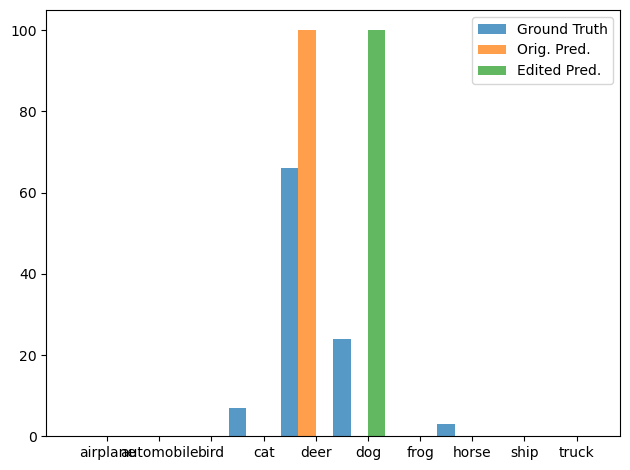

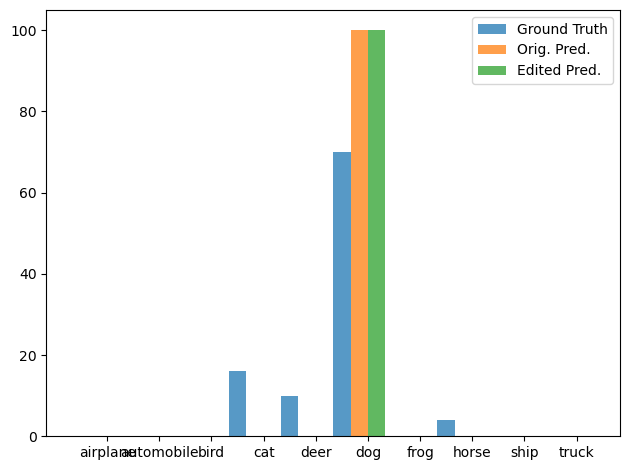

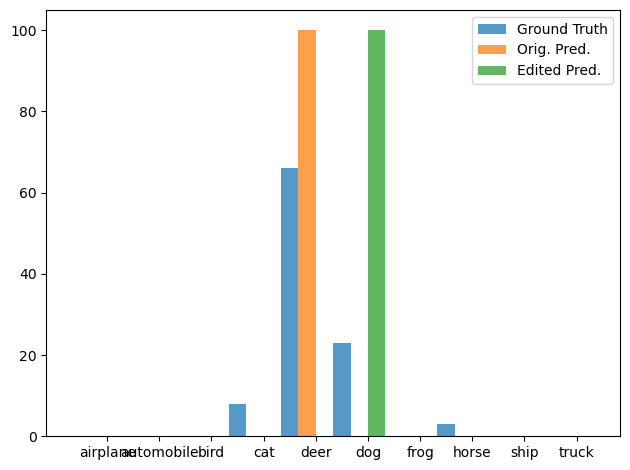

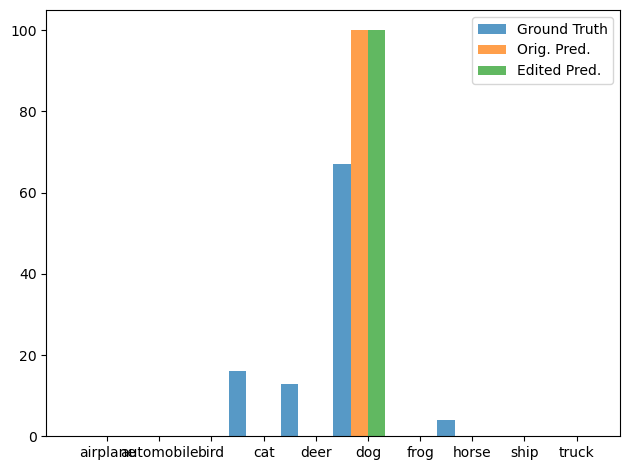

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3/models
Finished trial 8/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3
(0113_162135) Starting Trial 9/2008...
Current run_id: 0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02110806_2904.png
Value images: saved/segmentations/dog/dog

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.19it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11285263299942017 0.0066927094012498856
L2 norm of weight change: 0.4513884484767914
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.24it/s]


Post-edit metrics: {'TP': array([5912, 5826, 5126,    5, 3710, 5216, 5442, 5045, 4831, 4094]), 'TN': array([61058, 59848, 59878, 62993, 61303, 53037, 61649, 61890, 61608,
       61943]), 'FPs': array([1942, 3152, 3122,    7, 1697, 9963, 1351, 1110, 1392, 1057]), 'FNs': array([1088, 1174, 1874, 6995, 3290, 1784, 1558, 1955, 2169, 2906]), 'accuracy': 0.6458142857142857, 'per_class_accuracy': array([0.95671429, 0.9382    , 0.92862857, 0.89997143, 0.92875714,
       0.83218571, 0.95844286, 0.95621429, 0.94912857, 0.94338571]), 'per_class_accuracy_mean': 0.9291628571428572, 'precision': array([0.75273746, 0.64891958, 0.621484  , 0.41666667, 0.68614759,
       0.34363265, 0.8011188 , 0.81965881, 0.77631368, 0.79479713]), 'precision_mean': 0.6661476354023098, 'recall': array([8.44571429e-01, 8.32285714e-01, 7.32285714e-01, 7.14285714e-04,
       5.30000000e-01, 7.45142857e-01, 7.77428571e-01, 7.20714286e-01,
       6.90142857e-01, 5.84857143e-01]), 'recall_mean': 0.6458142857142857, 'f1': arr

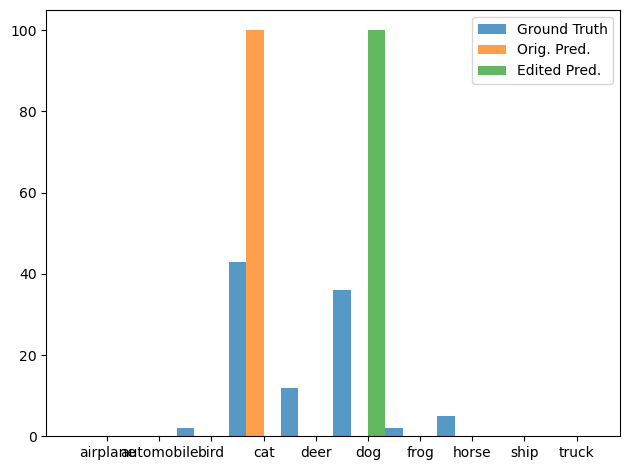

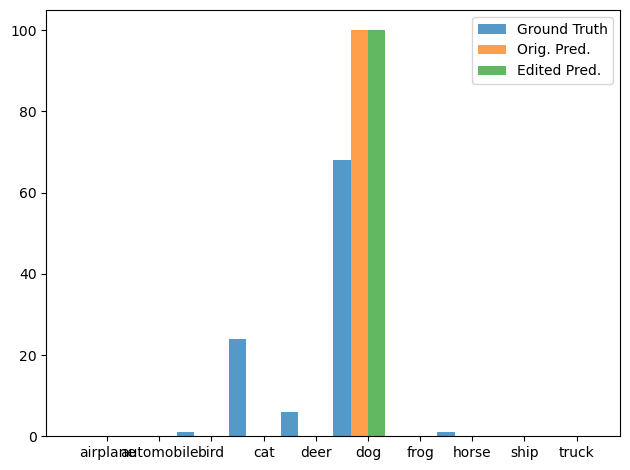

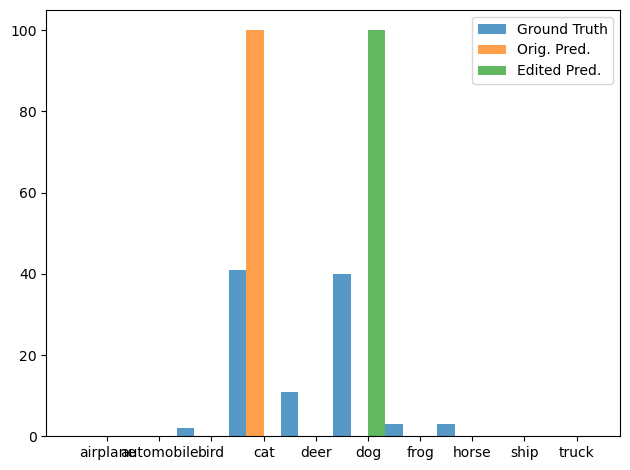

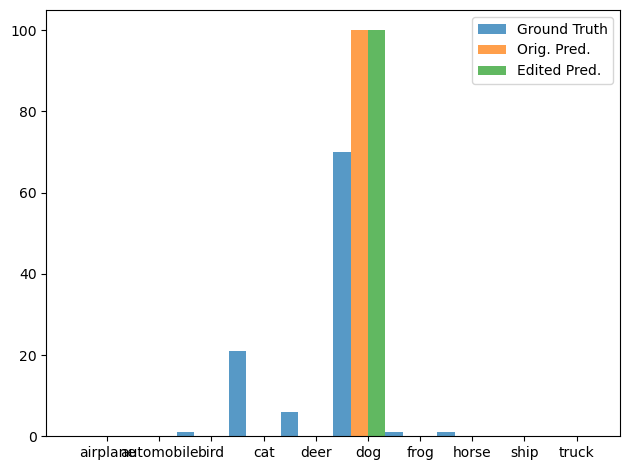

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1/models
Finished trial 9/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1
(0113_162259) Starting Trial 10/2008...
Current run_id: 0113_160154/dog-train-n02110806_2904/quickshift_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02110806_2904.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:07<00:00, 34.27it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.09714844077825546 0.006795305293053389
L2 norm of weight change: 0.3788413405418396
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 30.49it/s]


Post-edit metrics: {'TP': array([5985, 5729, 5216, 1404, 3883, 4710, 5486, 5403, 4738, 4330]), 'TN': array([60841, 60234, 59568, 62703, 60951, 56460, 61531, 61156, 61750,
       61690]), 'FPs': array([2159, 2766, 3432,  297, 2049, 6540, 1469, 1844, 1250, 1310]), 'FNs': array([1015, 1271, 1784, 5596, 3117, 2290, 1514, 1597, 2262, 2670]), 'accuracy': 0.6697714285714286, 'per_class_accuracy': array([0.95465714, 0.94232857, 0.92548571, 0.91581429, 0.9262    ,
       0.87385714, 0.95738571, 0.95084286, 0.94982857, 0.94314286]), 'per_class_accuracy_mean': 0.9339542857142857, 'precision': array([0.73489686, 0.6743967 , 0.60314524, 0.82539683, 0.6545853 ,
       0.41866667, 0.78878505, 0.74554988, 0.79124916, 0.7677305 ]), 'precision_mean': 0.7004402179438263, 'recall': array([0.855     , 0.81842857, 0.74514286, 0.20057143, 0.55471429,
       0.67285714, 0.78371429, 0.77185714, 0.67685714, 0.61857143]), 'recall_mean': 0.6697714285714286, 'f1': array([0.79041204, 0.73946434, 0.66666667, 0.32272

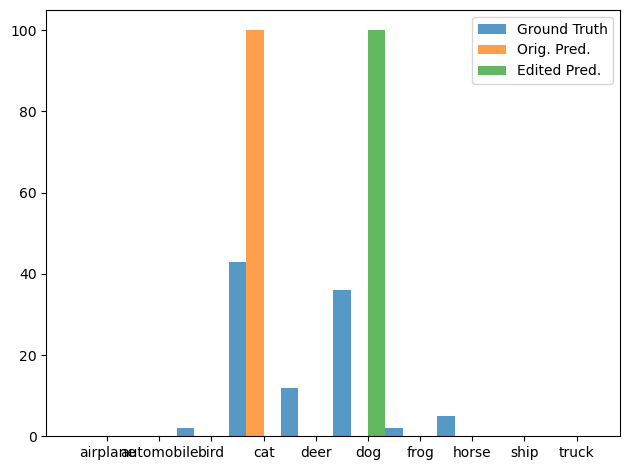

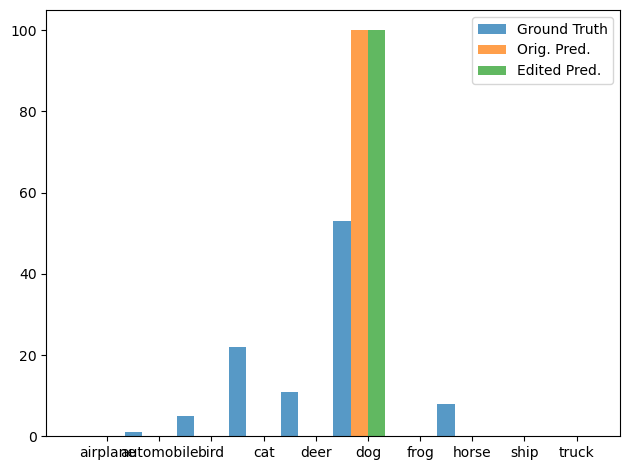

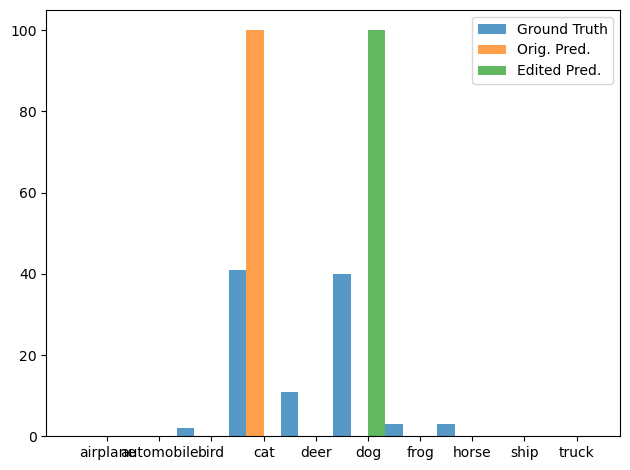

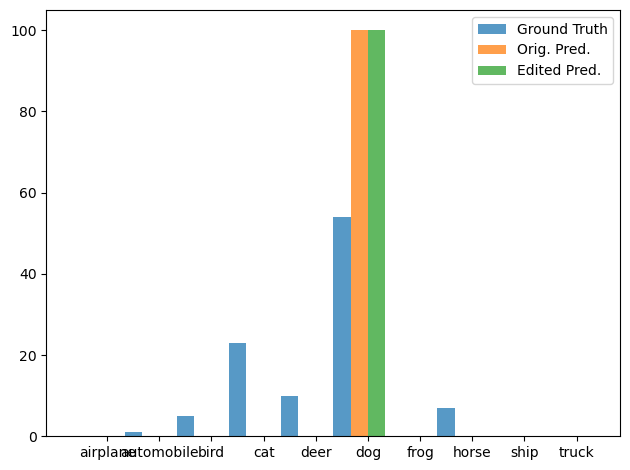

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2/models
Finished trial 10/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2
(0113_162425) Starting Trial 11/2008...
Current run_id: 0113_160154/dog-train-n02110806_2904/slic_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02110806_2904.png
Value images: saved/segmentations/dog/dog-train-n021108

100%|██████████████████████████████████████████| 274/274 [00:07<00:00, 34.27it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.118930384516716 0.008786763995885849
L2 norm of weight change: 0.4920872747898102
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.05it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5904, 5904, 5386,    0, 4032, 4816, 5424, 5099, 4849, 3877]), 'TN': array([61046, 59665, 58749, 63000, 60646, 55009, 61601, 61842, 61563,
       62170]), 'FPs': array([1954, 3335, 4251,    0, 2354, 7991, 1399, 1158, 1437,  830]), 'FNs': array([1096, 1096, 1614, 7000, 2968, 2184, 1576, 1901, 2151, 3123]), 'accuracy': 0.6470142857142858, 'per_class_accuracy': array([0.95642857, 0.9367    , 0.91621429, 0.9       , 0.92397143,
       0.85464286, 0.9575    , 0.9563    , 0.94874286, 0.94352857]), 'per_class_accuracy_mean': 0.9294028571428571, 'precision': array([0.75133622, 0.6390302 , 0.55888762, 0.        , 0.63138115,
       0.37604435, 0.79495823, 0.81492728, 0.77139675, 0.82366688]), 'precision_mean': 0.6161628678344245, 'recall': array([0.84342857, 0.84342857, 0.76942857, 0.        , 0.576     ,
       0.688     , 0.77485714, 0.72842857, 0.69271429, 0.55385714]), 'recall_mean': 0.6470142857142858, 'f1': array([0.79472338, 0.72713837, 0.6474725 , 0.     

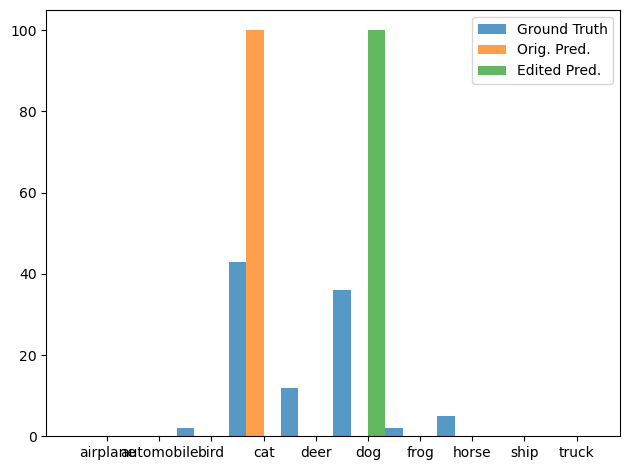

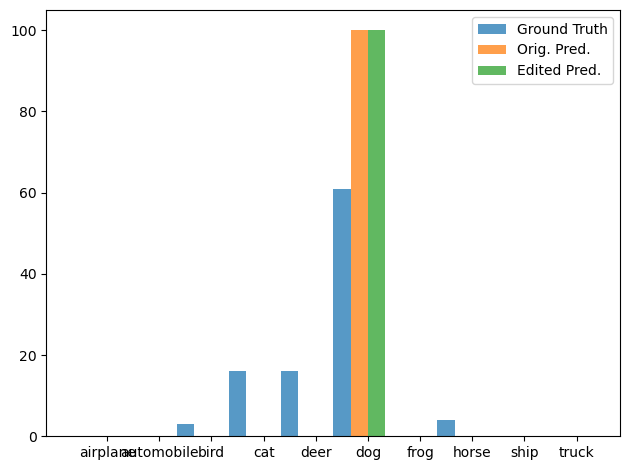

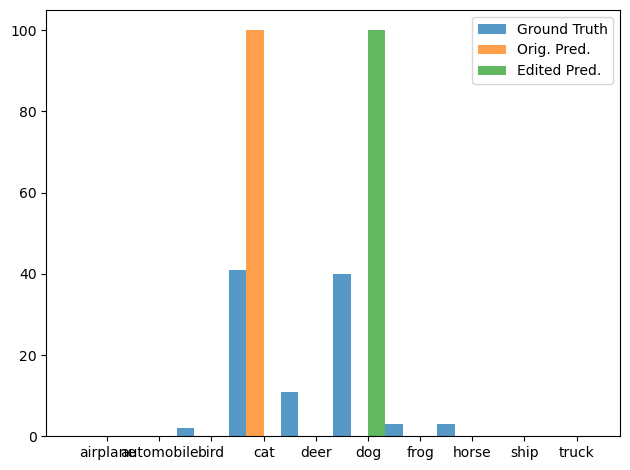

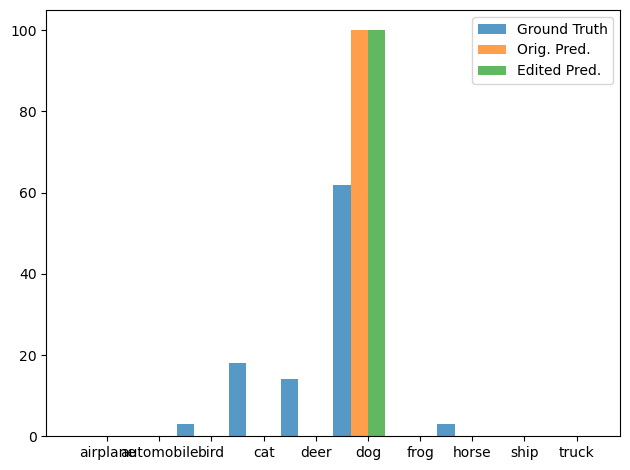

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3/models
Finished trial 11/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3
(0113_162551) Starting Trial 12/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n0211

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.73it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.08301715552806854 0.004099863115698099
L2 norm of weight change: 0.32286378741264343
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.89it/s]


Post-edit metrics: {'TP': array([6008, 5663, 5253, 2550, 4295, 4132, 5636, 5142, 4920, 4340]), 'TN': array([60722, 60556, 59293, 61923, 60054, 59348, 61118, 61774, 61468,
       61683]), 'FPs': array([2278, 2444, 3707, 1077, 2946, 3652, 1882, 1226, 1532, 1317]), 'FNs': array([ 992, 1337, 1747, 4450, 2705, 2868, 1364, 1858, 2080, 2660]), 'accuracy': 0.6848428571428572, 'per_class_accuracy': array([0.95328571, 0.94598571, 0.92208571, 0.92104286, 0.91927143,
       0.90685714, 0.95362857, 0.95594286, 0.9484    , 0.94318571]), 'per_class_accuracy_mean': 0.9369685714285714, 'precision': array([0.72507845, 0.69853213, 0.58627232, 0.70306038, 0.59315012,
       0.53083248, 0.74966746, 0.80747487, 0.76255425, 0.76719109]), 'precision_mean': 0.6923813551019127, 'recall': array([0.85828571, 0.809     , 0.75042857, 0.36428571, 0.61357143,
       0.59028571, 0.80514286, 0.73457143, 0.70285714, 0.62      ]), 'recall_mean': 0.6848428571428571, 'f1': array([0.78607876, 0.74971867, 0.65827068, 0.47990

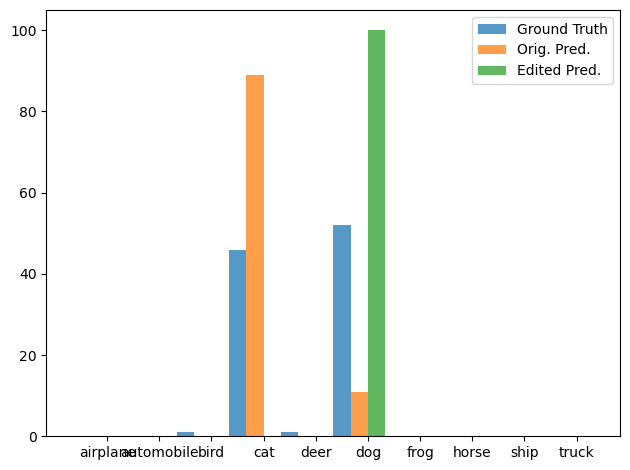

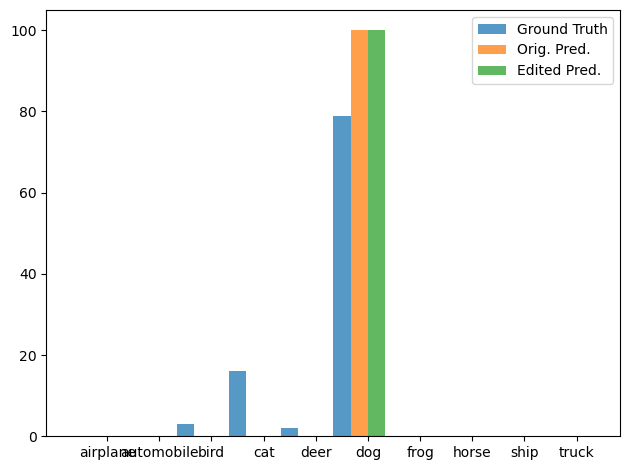

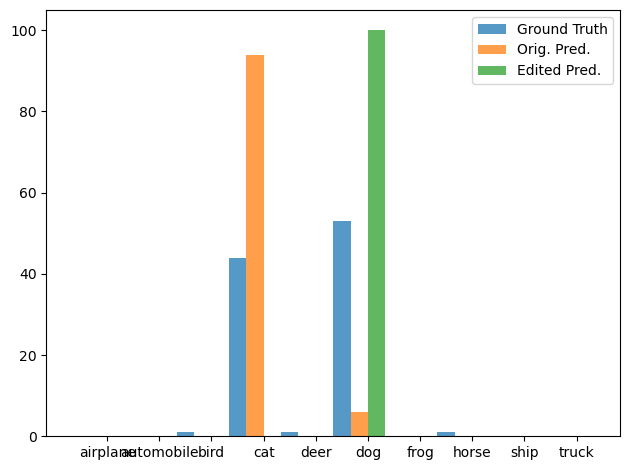

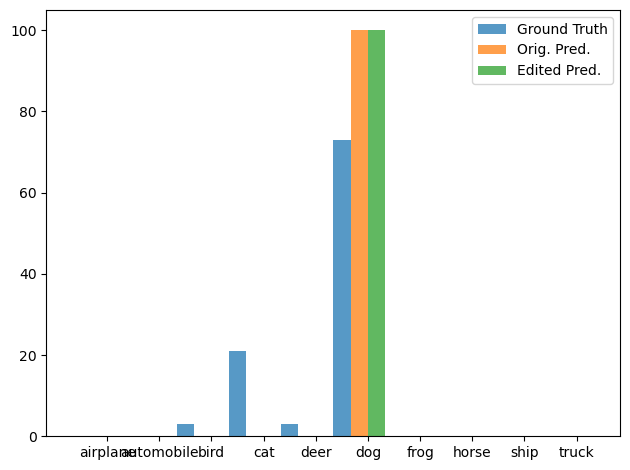

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0/models
Finished trial 12/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0
(0113_162713) Starting Trial 13/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/seg

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10132155567407608 0.004224040545523167
L2 norm of weight change: 0.4122808873653412
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 25.93it/s]


Post-edit metrics: {'TP': array([5947, 5746, 5265,   10, 4289, 4603, 5604, 5139, 4929, 4196]), 'TN': array([60875, 60291, 59249, 62960, 60083, 55971, 61210, 61795, 61452,
       61842]), 'FPs': array([2125, 2709, 3751,   40, 2917, 7029, 1790, 1205, 1548, 1158]), 'FNs': array([1053, 1254, 1735, 6990, 2711, 2397, 1396, 1861, 2071, 2804]), 'accuracy': 0.6532571428571429, 'per_class_accuracy': array([0.9546    , 0.94338571, 0.92162857, 0.89957143, 0.9196    ,
       0.86534286, 0.95448571, 0.9562    , 0.9483    , 0.9434    ]), 'per_class_accuracy_mean': 0.9306514285714286, 'precision': array([0.7367443 , 0.67959787, 0.58396185, 0.2       , 0.59519845,
       0.39571871, 0.75791182, 0.81005675, 0.76100046, 0.78371311]), 'precision_mean': 0.6303903312529865, 'recall': array([0.84957143, 0.82085714, 0.75214286, 0.00142857, 0.61271429,
       0.65757143, 0.80057143, 0.73414286, 0.70414286, 0.59942857]), 'recall_mean': 0.6532571428571429, 'f1': array([0.78914544, 0.74357813, 0.65746753, 0.00283

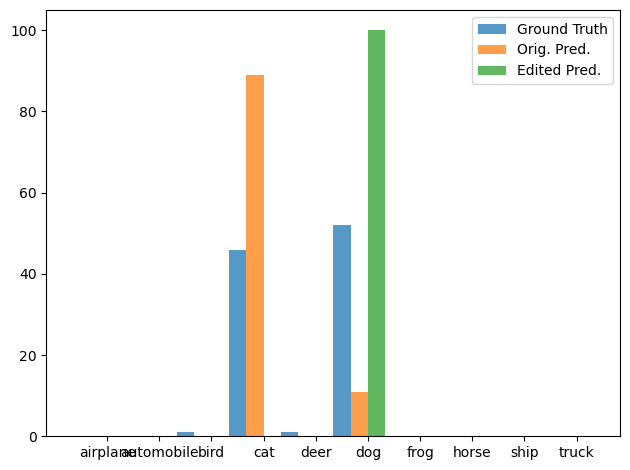

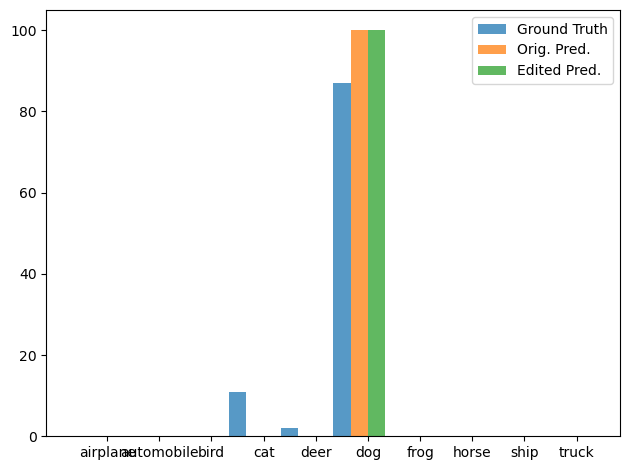

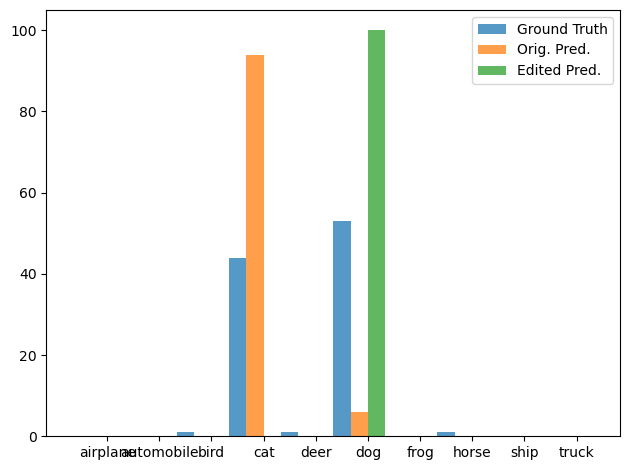

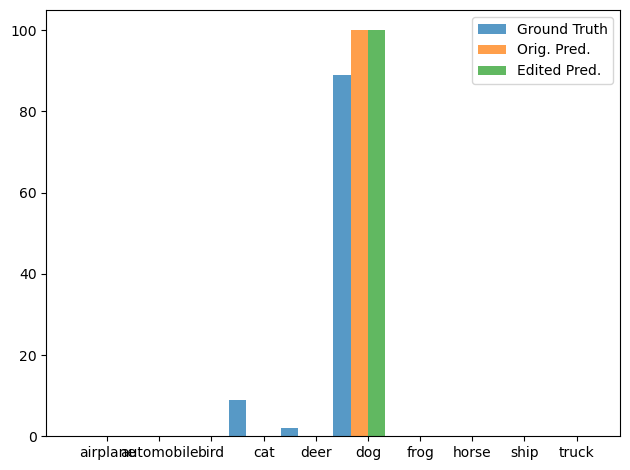

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1/models
Finished trial 13/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1
(0113_162839) Starting Trial 14/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segment

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.15it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11162541806697845 0.003484685905277729
L2 norm of weight change: 0.46592578291893005
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 23.76it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5925, 5793, 5272,    0, 4279, 4628, 5573, 5144, 4928, 4143]), 'TN': array([60966, 60147, 59255, 62999, 60106, 55784, 61294, 61777, 61461,
       61896]), 'FPs': array([2034, 2853, 3745,    1, 2894, 7216, 1706, 1223, 1539, 1104]), 'FNs': array([1075, 1207, 1728, 7000, 2721, 2372, 1427, 1856, 2072, 2857]), 'accuracy': 0.6526428571428572, 'per_class_accuracy': array([0.95558571, 0.942     , 0.92181429, 0.89998571, 0.91978571,
       0.86302857, 0.95524286, 0.95601429, 0.94841429, 0.94341429]), 'per_class_accuracy_mean': 0.9305285714285713, 'precision': array([0.74444026, 0.67002082, 0.58467339, 0.        , 0.59654259,
       0.39074637, 0.76562715, 0.80791582, 0.76202258, 0.78959405]), 'precision_mean': 0.611158302203993, 'recall': array([0.84642857, 0.82757143, 0.75314286, 0.        , 0.61128571,
       0.66114286, 0.79614286, 0.73485714, 0.704     , 0.59185714]), 'recall_mean': 0.6526428571428571, 'f1': array([0.79216525, 0.74050876, 0.65830056, 0.      

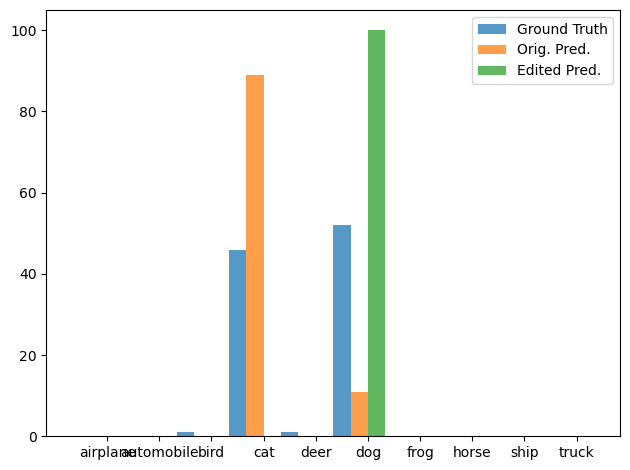

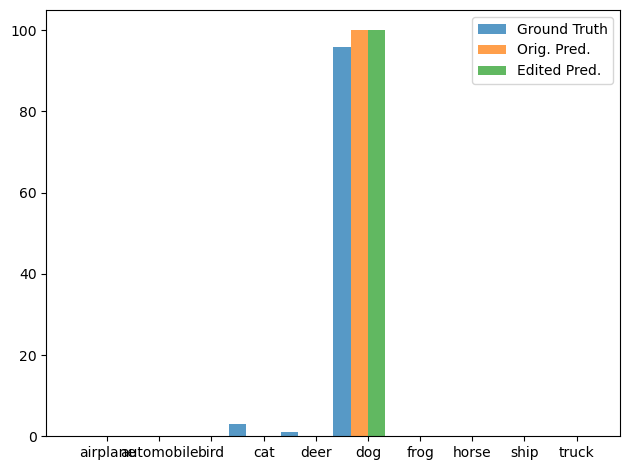

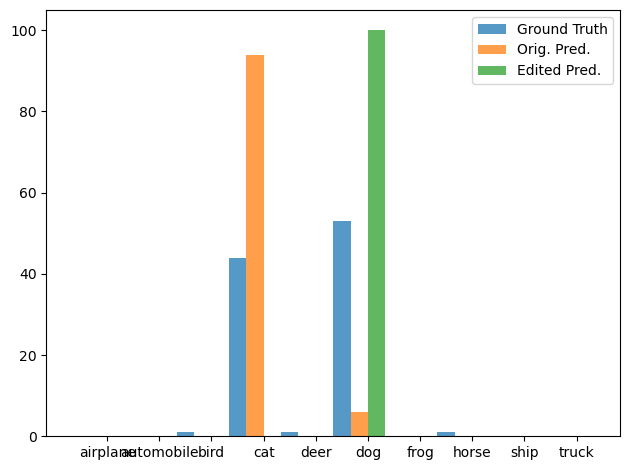

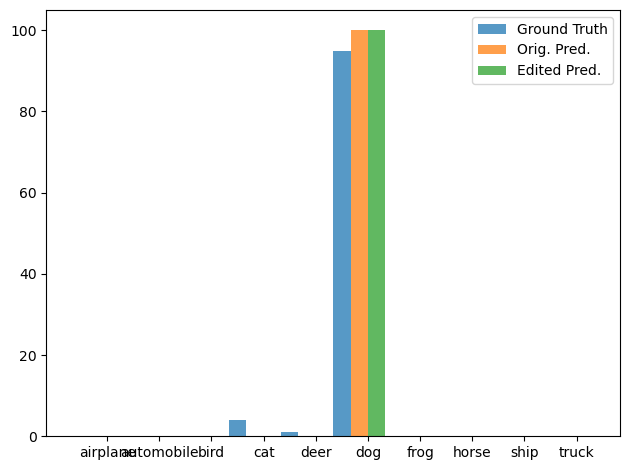

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0/models
Finished trial 14/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0
(0113_163007) Starting Trial 15/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.49it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.10099630802869797 0.004372484050691128
L2 norm of weight change: 0.4099348783493042
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 24.22it/s]


Post-edit metrics: {'TP': array([5955, 5745, 5263,   12, 4302, 4588, 5605, 5135, 4940, 4203]), 'TN': array([60853, 60306, 59251, 62961, 60042, 56054, 61207, 61802, 61435,
       61837]), 'FPs': array([2147, 2694, 3749,   39, 2958, 6946, 1793, 1198, 1565, 1163]), 'FNs': array([1045, 1255, 1737, 6988, 2698, 2412, 1395, 1865, 2060, 2797]), 'accuracy': 0.6535428571428571, 'per_class_accuracy': array([0.9544    , 0.94358571, 0.92162857, 0.89961429, 0.9192    ,
       0.86631429, 0.95445714, 0.95624286, 0.94821429, 0.94342857]), 'per_class_accuracy_mean': 0.9307085714285714, 'precision': array([0.7350037 , 0.68076786, 0.58399911, 0.23529412, 0.59256198,
       0.39778048, 0.7576372 , 0.81083215, 0.75941583, 0.783265  ]), 'precision_mean': 0.6336557438951235, 'recall': array([0.85071429, 0.82071429, 0.75185714, 0.00171429, 0.61457143,
       0.65542857, 0.80071429, 0.73357143, 0.70571429, 0.60042857]), 'recall_mean': 0.6535428571428571, 'f1': array([0.78863727, 0.74421919, 0.65738196, 0.00340

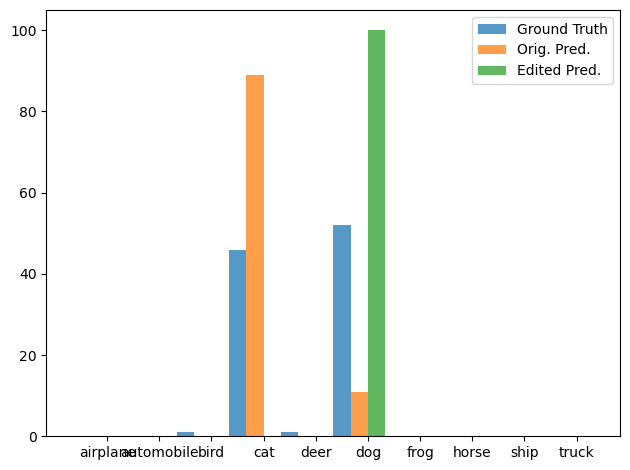

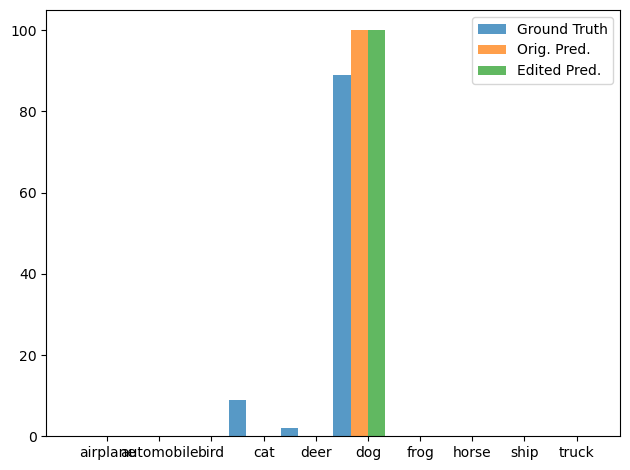

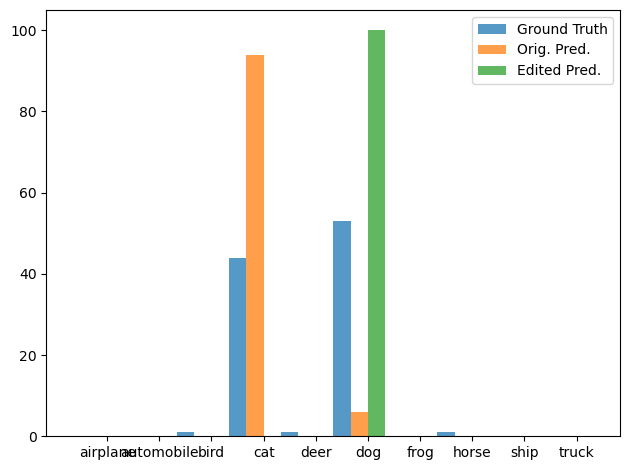

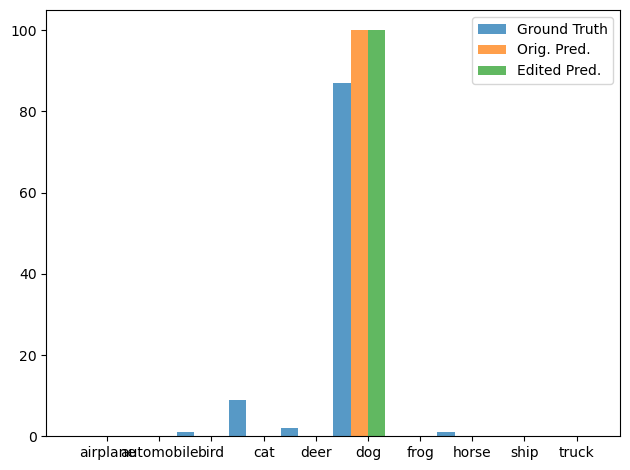

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1/models
Finished trial 15/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1
(0113_163136) Starting Trial 16/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.91it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.030310507863759995 0.004133759997785091
L2 norm of weight change: 0.16703422367572784
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.38it/s]


Post-edit metrics: {'TP': array([6087, 5465, 5222, 3617, 4286, 3269, 5631, 5178, 4862, 4590]), 'TN': array([60351, 60996, 59382, 60361, 60061, 61324, 61117, 61665, 61589,
       61361]), 'FPs': array([2649, 2004, 3618, 2639, 2939, 1676, 1883, 1335, 1411, 1639]), 'FNs': array([ 913, 1535, 1778, 3383, 2714, 3731, 1369, 1822, 2138, 2410]), 'accuracy': 0.6886714285714286, 'per_class_accuracy': array([0.94911429, 0.94944286, 0.92291429, 0.91397143, 0.91924286,
       0.92275714, 0.95354286, 0.9549    , 0.9493    , 0.94215714]), 'per_class_accuracy_mean': 0.9377342857142859, 'precision': array([0.69677198, 0.73169099, 0.59072398, 0.57816496, 0.59321799,
       0.66107179, 0.74940112, 0.79502533, 0.77506775, 0.7368759 ]), 'precision_mean': 0.6908011799320765, 'recall': array([0.86957143, 0.78071429, 0.746     , 0.51671429, 0.61228571,
       0.467     , 0.80442857, 0.73971429, 0.69457143, 0.65571429]), 'recall_mean': 0.6886714285714286, 'f1': array([0.77364006, 0.75540811, 0.65934343, 0.54571

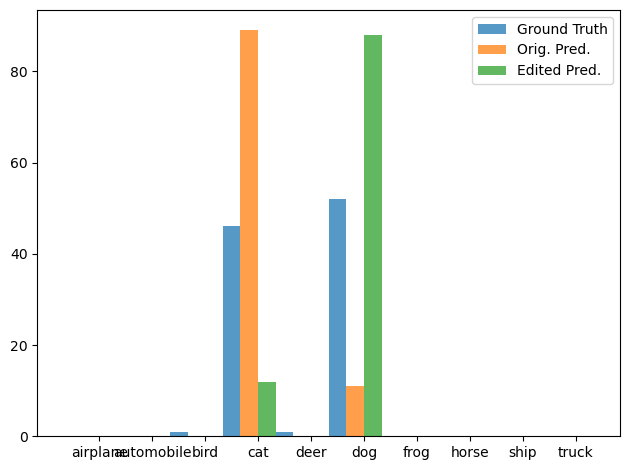

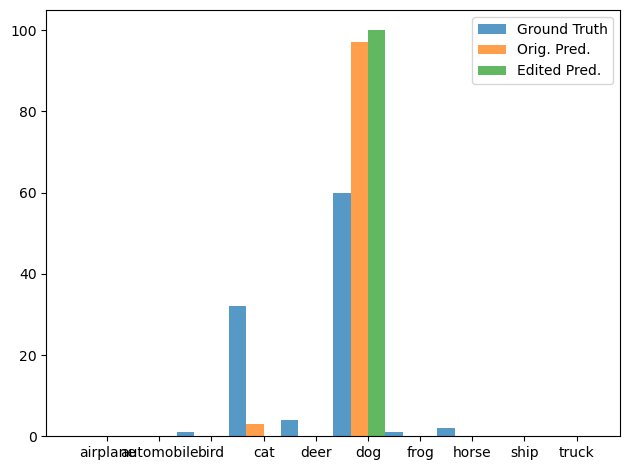

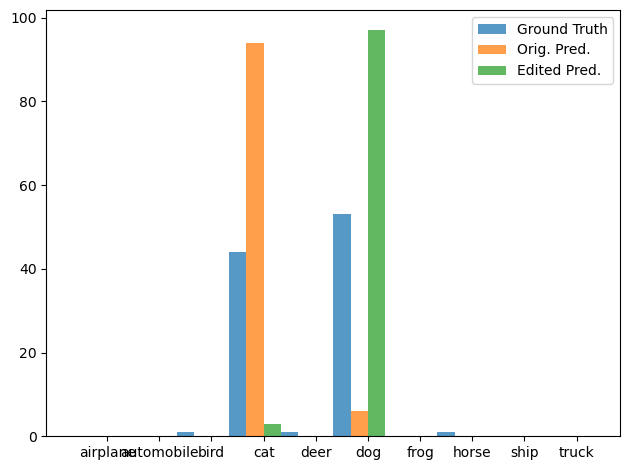

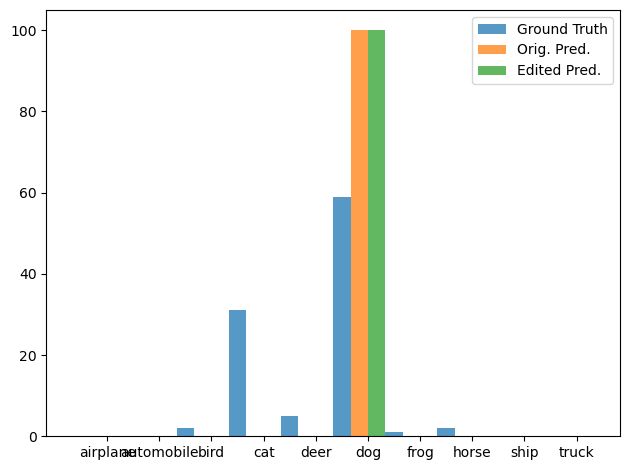

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3/models
Finished trial 16/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3
(0113_163303) Starting Trial 17/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.48it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09574900567531586 0.004116373136639595
L2 norm of weight change: 0.37683358788490295
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.17it/s]


Post-edit metrics: {'TP': array([5968, 5710, 5261,  431, 4294, 4560, 5610, 5133, 4933, 4248]), 'TN': array([60818, 60398, 59266, 62841, 60076, 56535, 61183, 61805, 61445,
       61781]), 'FPs': array([2182, 2602, 3734,  159, 2924, 6465, 1817, 1195, 1555, 1219]), 'FNs': array([1032, 1290, 1739, 6569, 2706, 2440, 1390, 1867, 2067, 2752]), 'accuracy': 0.6592571428571429, 'per_class_accuracy': array([0.95408571, 0.9444    , 0.92181429, 0.90388571, 0.91957143,
       0.87278571, 0.95418571, 0.95625714, 0.94825714, 0.94327143]), 'per_class_accuracy_mean': 0.9318514285714287, 'precision': array([0.73226994, 0.68695861, 0.58488049, 0.73050847, 0.59490163,
       0.41360544, 0.75535209, 0.81115676, 0.76032676, 0.77702579]), 'precision_mean': 0.6846985998920785, 'recall': array([0.85257143, 0.81571429, 0.75157143, 0.06157143, 0.61342857,
       0.65142857, 0.80142857, 0.73328571, 0.70471429, 0.60685714]), 'recall_mean': 0.6592571428571429, 'f1': array([0.78785479, 0.74582027, 0.65783057, 0.11357

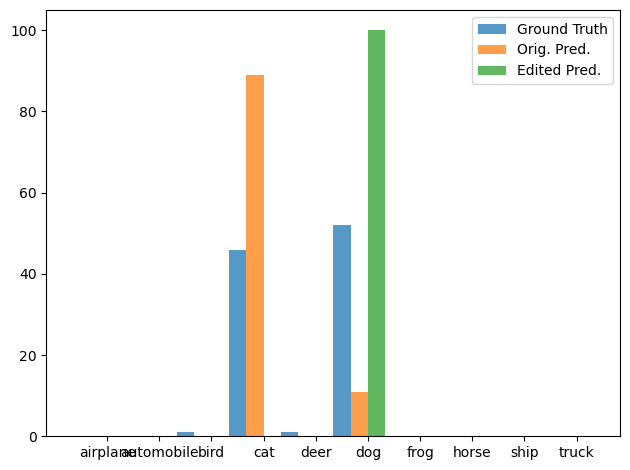

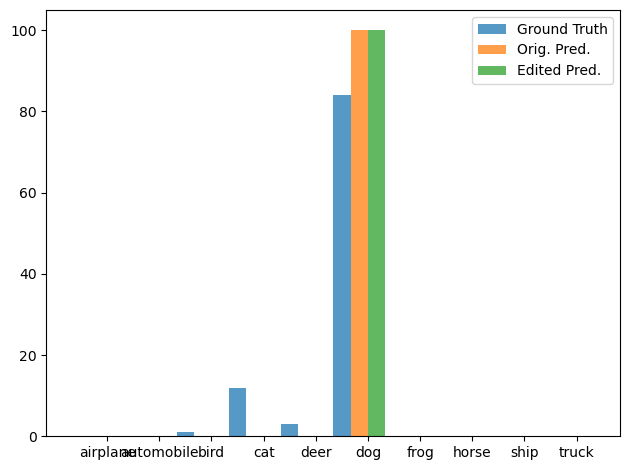

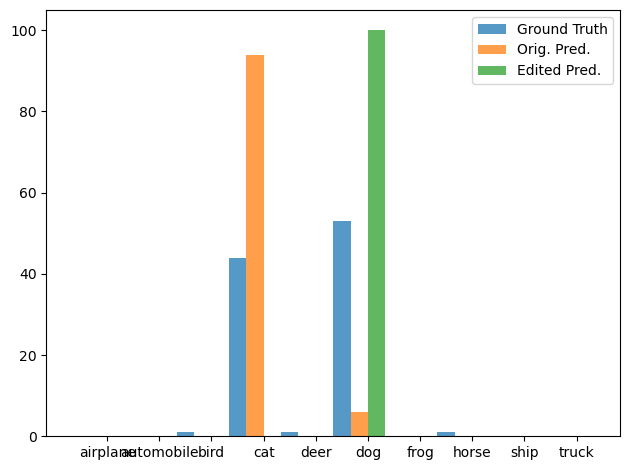

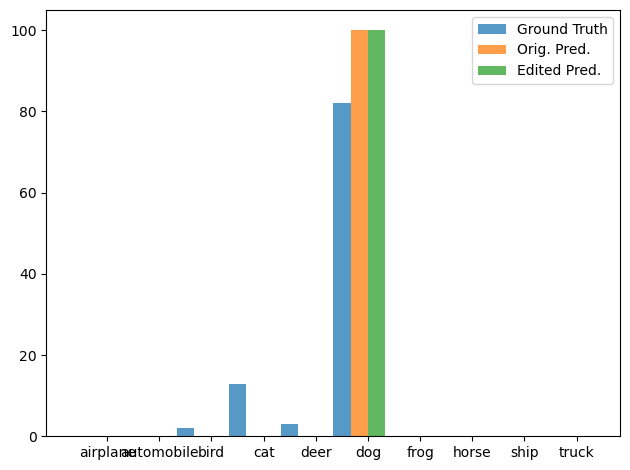

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1/models
Finished trial 17/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1
(0113_163430) Starting Trial 18/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.26it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.019462063908576965 0.003641663584858179
L2 norm of weight change: 0.15008053183555603
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.28it/s]


Post-edit metrics: {'TP': array([6096, 5435, 5207, 3739, 4276, 3203, 5645, 5142, 4889, 4606]), 'TN': array([60325, 61014, 59482, 60133, 60131, 61431, 61092, 61767, 61558,
       61305]), 'FPs': array([2675, 1986, 3518, 2867, 2869, 1569, 1908, 1233, 1442, 1695]), 'FNs': array([ 904, 1565, 1793, 3261, 2724, 3797, 1355, 1858, 2111, 2394]), 'accuracy': 0.6891142857142857, 'per_class_accuracy': array([0.94887143, 0.94927143, 0.92412857, 0.91245714, 0.9201    ,
       0.92334286, 0.95338571, 0.95584286, 0.94924286, 0.94158571]), 'per_class_accuracy_mean': 0.9378228571428572, 'precision': array([0.69501767, 0.73238108, 0.59679083, 0.56600061, 0.59846046,
       0.67120704, 0.74738514, 0.80658824, 0.77223187, 0.73099508]), 'precision_mean': 0.6917058027297083, 'recall': array([0.87085714, 0.77642857, 0.74385714, 0.53414286, 0.61085714,
       0.45757143, 0.80642857, 0.73457143, 0.69842857, 0.658     ]), 'recall_mean': 0.6891142857142858, 'f1': array([0.77306449, 0.75376188, 0.66225755, 0.54961

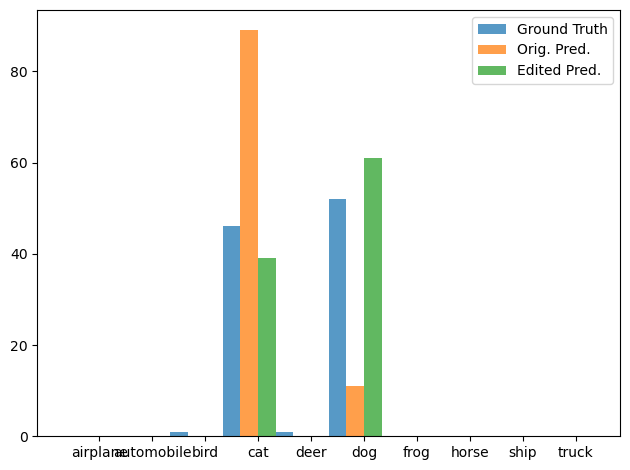

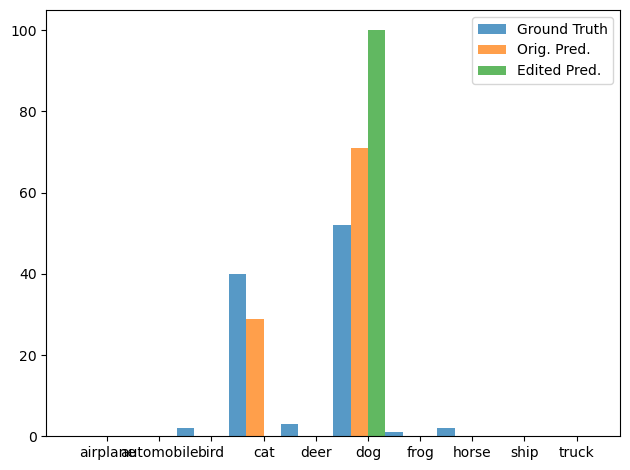

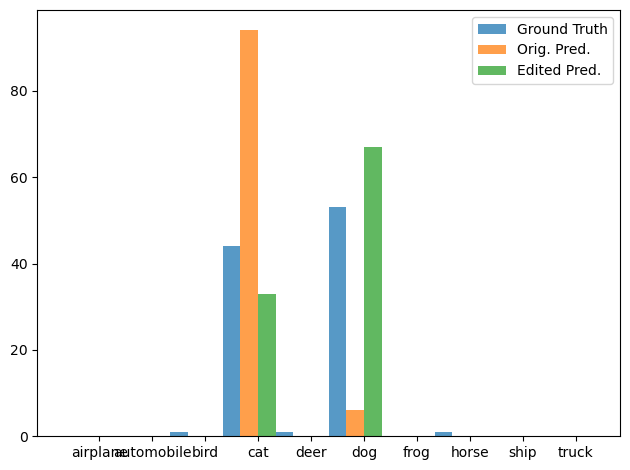

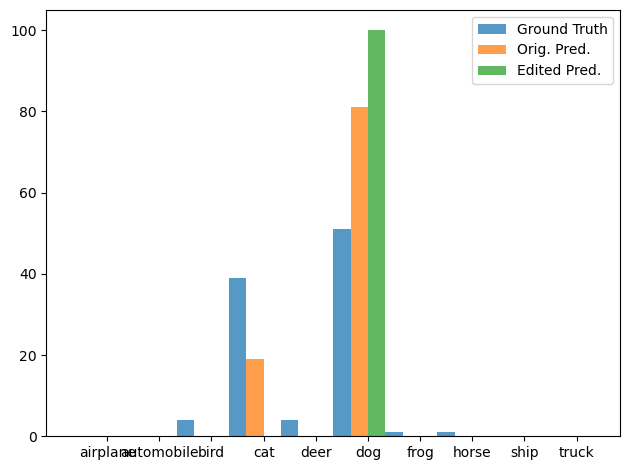

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4/models
Finished trial 18/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4
(0113_163557) Starting Trial 19/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.24it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.017008241266012192 0.003090193960815668
L2 norm of weight change: 0.14946067333221436
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.27it/s]


Post-edit metrics: {'TP': array([6103, 5431, 5206, 3770, 4264, 3184, 5643, 5145, 4878, 4618]), 'TN': array([60293, 61029, 59477, 60076, 60151, 61468, 61103, 61764, 61584,
       61297]), 'FPs': array([2707, 1971, 3523, 2924, 2849, 1532, 1897, 1236, 1416, 1703]), 'FNs': array([ 897, 1569, 1794, 3230, 2736, 3816, 1357, 1855, 2122, 2382]), 'accuracy': 0.6891714285714285, 'per_class_accuracy': array([0.94851429, 0.94942857, 0.92404286, 0.91208571, 0.92021429,
       0.9236    , 0.95351429, 0.95584286, 0.94945714, 0.94164286]), 'per_class_accuracy_mean': 0.9378342857142858, 'precision': array([0.69273553, 0.73372062, 0.5964028 , 0.56319092, 0.59946577,
       0.67514843, 0.74840849, 0.80629995, 0.77502383, 0.7305806 ]), 'precision_mean': 0.6920976931762737, 'recall': array([0.87185714, 0.77585714, 0.74371429, 0.53857143, 0.60914286,
       0.45485714, 0.80614286, 0.735     , 0.69685714, 0.65971429]), 'recall_mean': 0.6891714285714284, 'f1': array([0.77204301, 0.75420081, 0.66196198, 0.55060

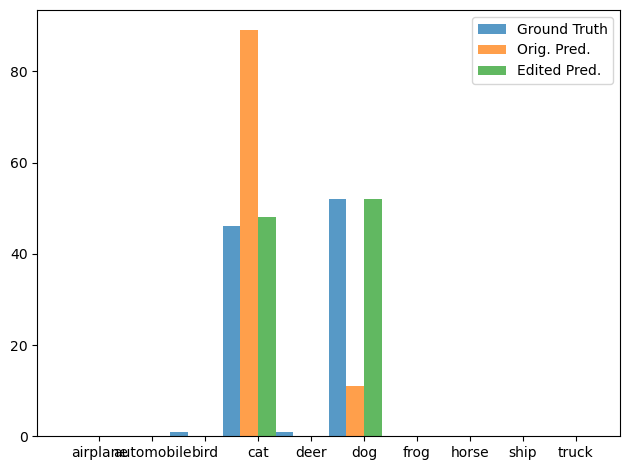

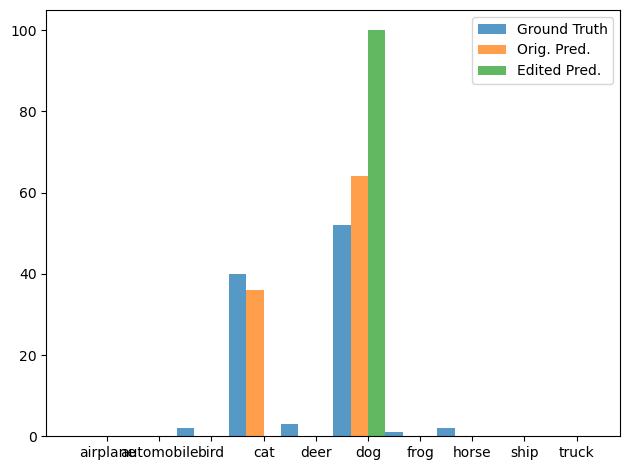

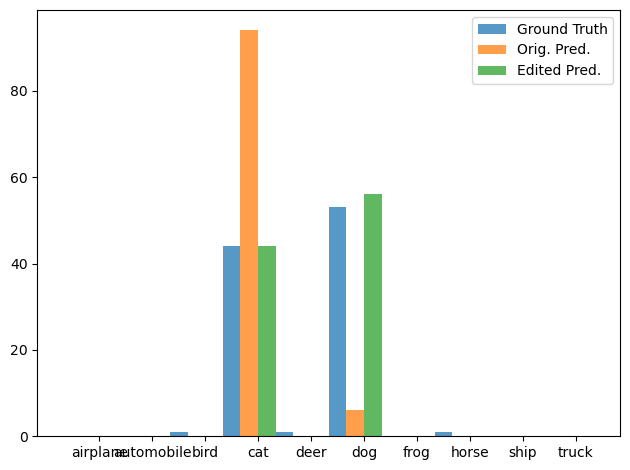

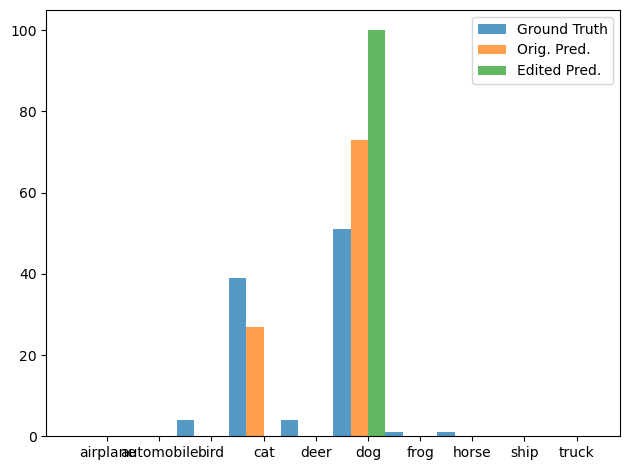

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0/models
Finished trial 19/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0
(0113_163725) Starting Trial 20/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-t

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.26it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10517062246799469 0.00413911510258913
L2 norm of weight change: 0.43798911571502686
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.00it/s]


Post-edit metrics: {'TP': array([5940, 5766, 5266,    1, 4289, 4609, 5592, 5144, 4926, 4177]), 'TN': array([60904, 60223, 59250, 62991, 60078, 55909, 61253, 61785, 61454,
       61863]), 'FPs': array([2096, 2777, 3750,    9, 2922, 7091, 1747, 1215, 1546, 1137]), 'FNs': array([1060, 1234, 1734, 6999, 2711, 2391, 1408, 1856, 2074, 2823]), 'accuracy': 0.653, 'per_class_accuracy': array([0.95491429, 0.9427    , 0.92165714, 0.89988571, 0.91952857,
       0.86454286, 0.95492857, 0.95612857, 0.94828571, 0.94342857]), 'per_class_accuracy_mean': 0.9305999999999999, 'precision': array([0.73917372, 0.67493855, 0.58407276, 0.1       , 0.59478574,
       0.39393162, 0.76195667, 0.80893222, 0.76112485, 0.78603688]), 'precision_mean': 0.6204953013003596, 'recall': array([8.48571429e-01, 8.23714286e-01, 7.52285714e-01, 1.42857143e-04,
       6.12714286e-01, 6.58428571e-01, 7.98857143e-01, 7.34857143e-01,
       7.03714286e-01, 5.96714286e-01]), 'recall_mean': 0.653, 'f1': array([7.90103751e-01, 7.4194

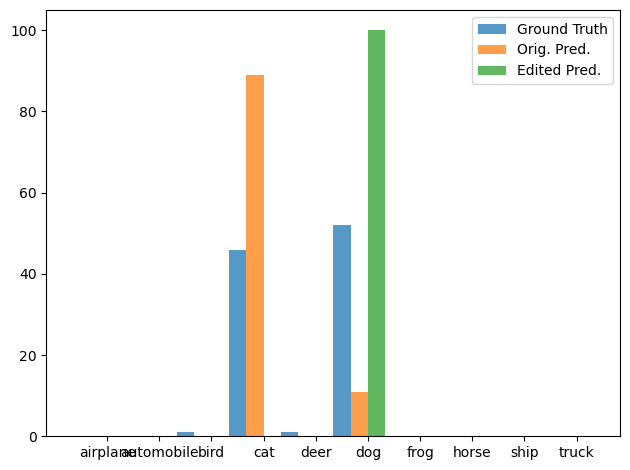

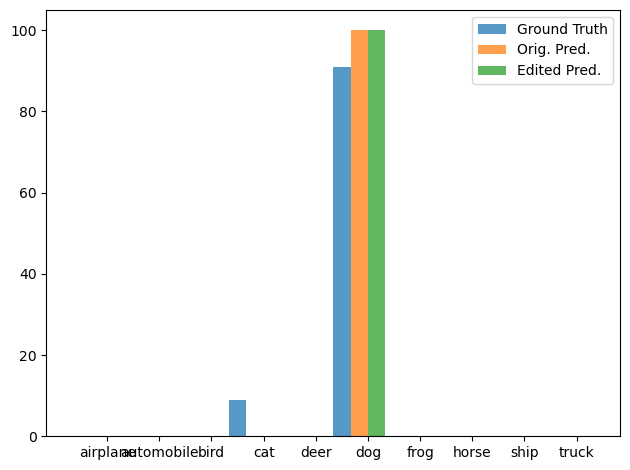

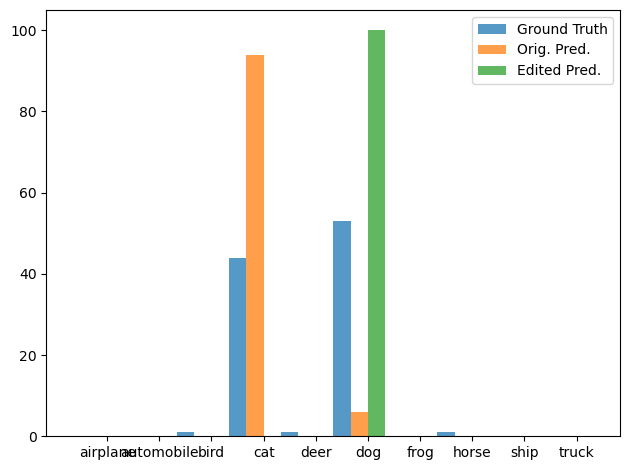

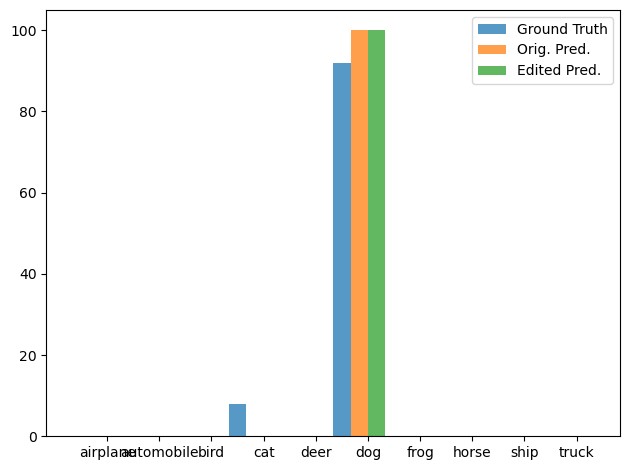

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1/models
Finished trial 20/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1
(0113_163849) Starting Trial 21/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-t

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.71it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.0927850678563118 0.00511441333219409
L2 norm of weight change: 0.33879563212394714
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.22it/s]


Post-edit metrics: {'TP': array([6083, 5701, 5291, 2331, 4334, 3967, 5632, 5170, 4901, 4250]), 'TN': array([60286, 60406, 59032, 62196, 59913, 59794, 61124, 61688, 61468,
       61753]), 'FPs': array([2714, 2594, 3968,  804, 3087, 3206, 1876, 1312, 1532, 1247]), 'FNs': array([ 917, 1299, 1709, 4669, 2666, 3033, 1368, 1830, 2099, 2750]), 'accuracy': 0.6808571428571428, 'per_class_accuracy': array([0.94812857, 0.94438571, 0.9189    , 0.92181429, 0.91781429,
       0.91087143, 0.95365714, 0.95511429, 0.94812857, 0.9429    ]), 'per_class_accuracy_mean': 0.9361714285714285, 'precision': array([0.69148573, 0.68728149, 0.571444  , 0.74354067, 0.58401833,
       0.55304615, 0.75013319, 0.79759334, 0.76185295, 0.77314899]), 'precision_mean': 0.691354483333569, 'recall': array([0.869     , 0.81442857, 0.75585714, 0.333     , 0.61914286,
       0.56671429, 0.80457143, 0.73857143, 0.70014286, 0.60714286]), 'recall_mean': 0.6808571428571428, 'f1': array([0.77014623, 0.74547238, 0.65083954, 0.459990

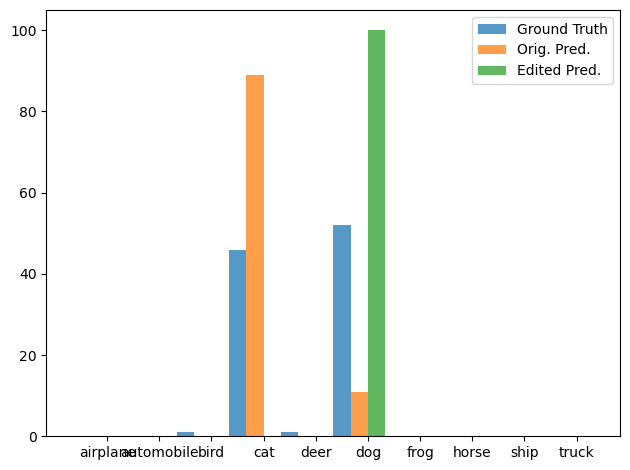

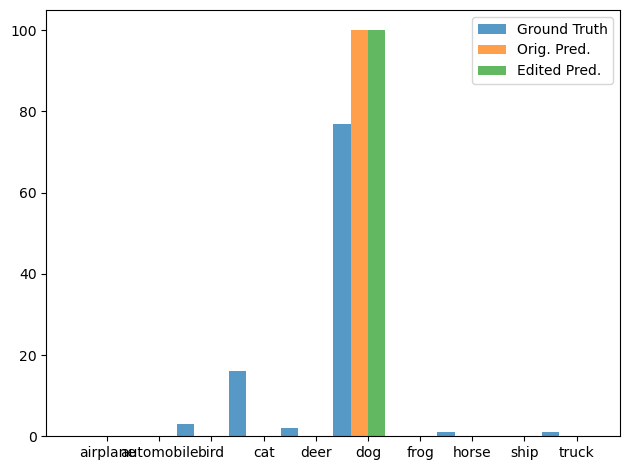

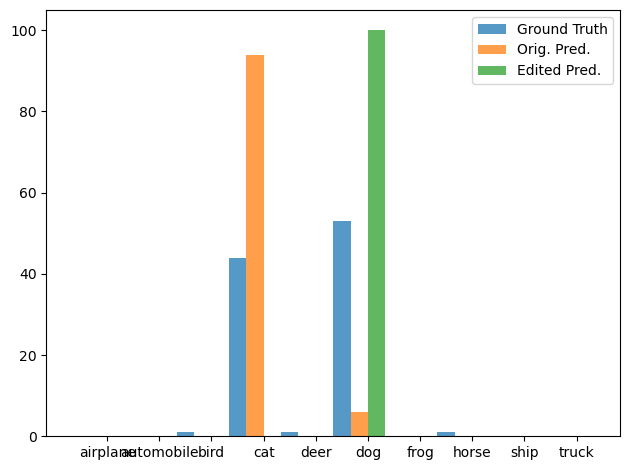

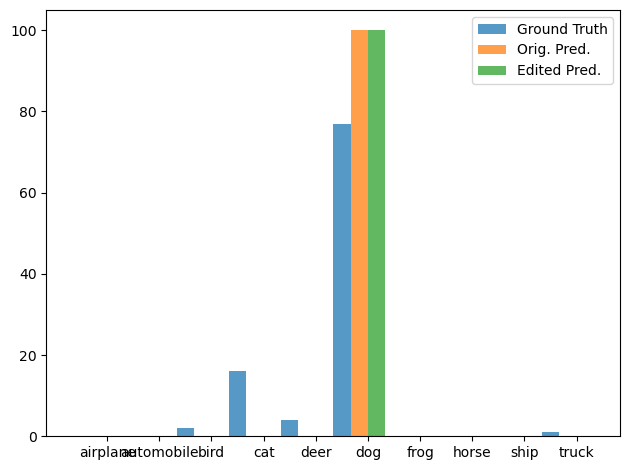

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3/models
Finished trial 21/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3
(0113_164015) Starting Trial 22/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.07it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10906830430030823 0.004128840286284685
L2 norm of weight change: 0.45239508152008057
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.50it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5928, 5783, 5267,    0, 4281, 4631, 5575, 5139, 4931, 4154]), 'TN': array([60948, 60201, 59255, 62997, 60102, 55770, 61287, 61788, 61454,
       61887]), 'FPs': array([2052, 2799, 3745,    3, 2898, 7230, 1713, 1212, 1546, 1113]), 'FNs': array([1072, 1217, 1733, 7000, 2719, 2369, 1425, 1861, 2069, 2846]), 'accuracy': 0.6527, 'per_class_accuracy': array([0.95537143, 0.94262857, 0.92174286, 0.89995714, 0.91975714,
       0.86287143, 0.95517143, 0.9561    , 0.94835714, 0.94344286]), 'per_class_accuracy_mean': 0.93054, 'precision': array([0.74285714, 0.67385225, 0.58444296, 0.        , 0.59632261,
       0.39043925, 0.76495609, 0.80916391, 0.76130925, 0.78868426]), 'precision_mean': 0.6112027730991599, 'recall': array([0.84685714, 0.82614286, 0.75242857, 0.        , 0.61157143,
       0.66157143, 0.79642857, 0.73414286, 0.70442857, 0.59342857]), 'recall_mean': 0.6527, 'f1': array([0.79145527, 0.74226672, 0.65788159, 0.        , 0.60385077,
       0.49106622,

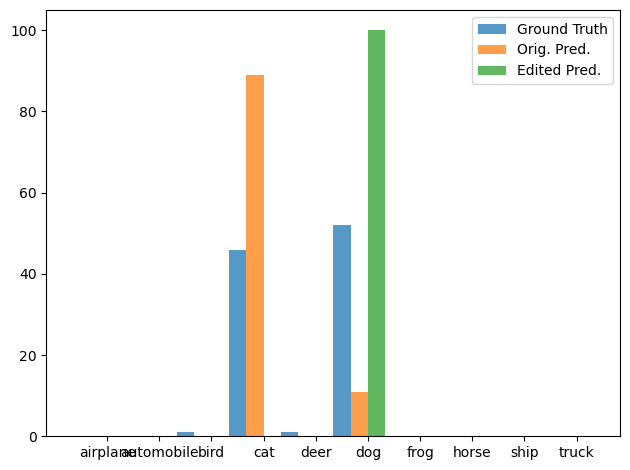

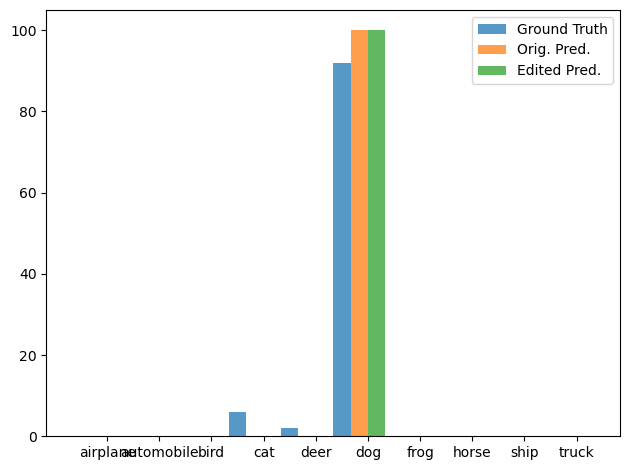

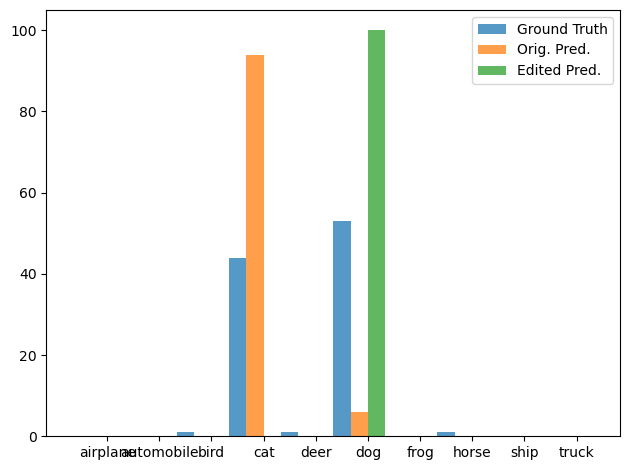

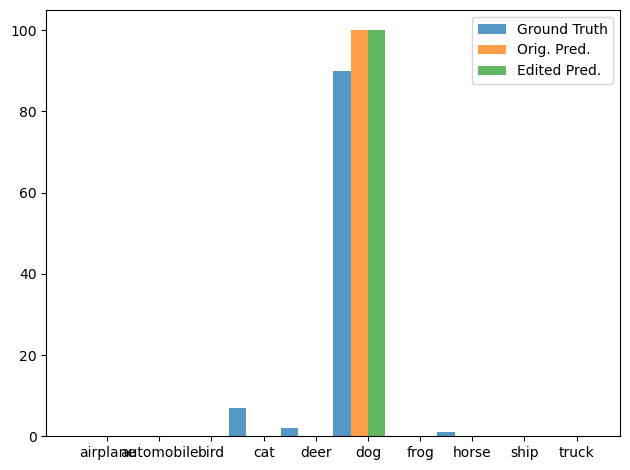

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0/models
Finished trial 22/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0
(0113_164137) Starting Trial 23/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.23it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.03922880068421364 0.003921233583241701
L2 norm of weight change: 0.19532062113285065
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.63it/s]


Post-edit metrics: {'TP': array([6065, 5507, 5216, 3510, 4272, 3438, 5640, 5151, 4906, 4532]), 'TN': array([60442, 60890, 59425, 60535, 60110, 61064, 61095, 61738, 61523,
       61415]), 'FPs': array([2558, 2110, 3575, 2465, 2890, 1936, 1905, 1262, 1477, 1585]), 'FNs': array([ 935, 1493, 1784, 3490, 2728, 3562, 1360, 1849, 2094, 2468]), 'accuracy': 0.6891, 'per_class_accuracy': array([0.9501    , 0.94852857, 0.92344286, 0.91492857, 0.91974286,
       0.92145714, 0.95335714, 0.95555714, 0.94898571, 0.9421    ]), 'per_class_accuracy_mean': 0.93782, 'precision': array([0.7033515 , 0.72298805, 0.59333409, 0.5874477 , 0.59648143,
       0.63974693, 0.74751491, 0.80321223, 0.7686041 , 0.74088606]), 'precision_mean': 0.690356700030901, 'recall': array([0.86642857, 0.78671429, 0.74514286, 0.50142857, 0.61028571,
       0.49114286, 0.80571429, 0.73585714, 0.70085714, 0.64742857]), 'recall_mean': 0.6891, 'f1': array([0.77641938, 0.75350619, 0.66062947, 0.54104046, 0.60330462,
       0.55568127, 

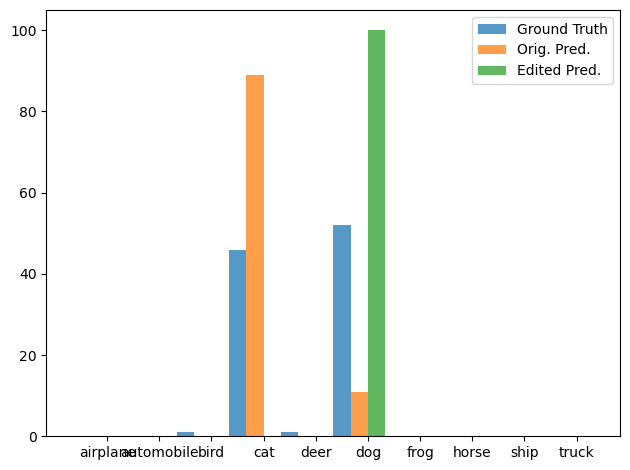

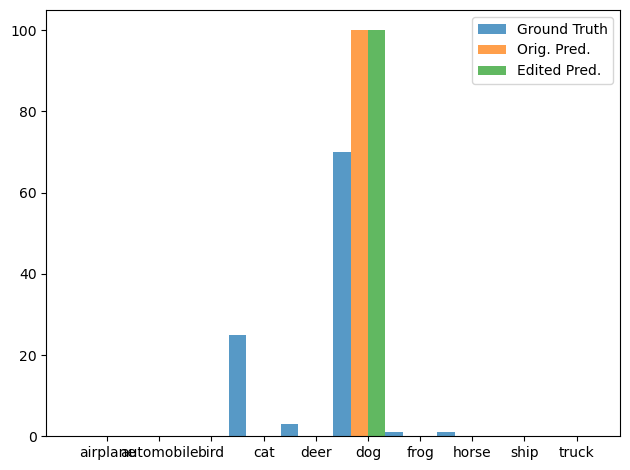

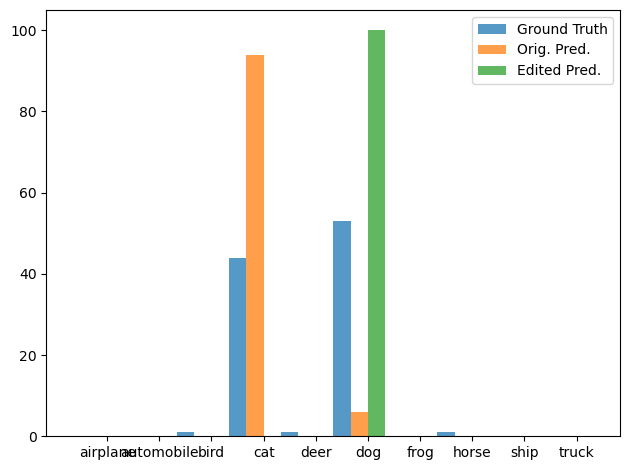

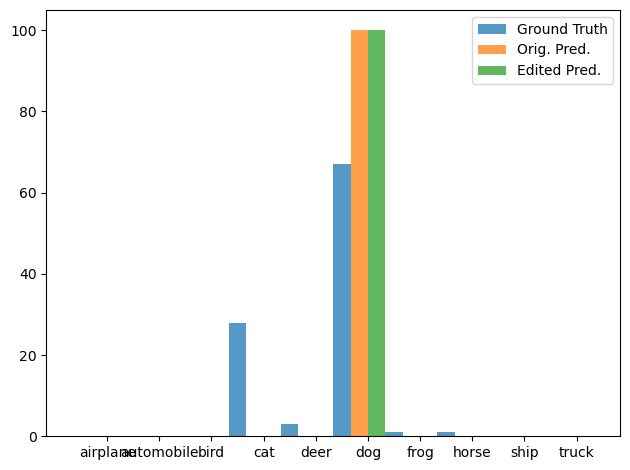

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2/models
Finished trial 23/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2
(0113_164303) Starting Trial 24/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.02it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.015964573249220848 0.003288794308900833
L2 norm of weight change: 0.14656025171279907
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:14<00:00, 18.85it/s]


Post-edit metrics: {'TP': array([6104, 5427, 5206, 3773, 4267, 3164, 5643, 5146, 4878, 4625]), 'TN': array([60289, 61038, 59481, 60062, 60143, 61483, 61101, 61765, 61582,
       61289]), 'FPs': array([2711, 1962, 3519, 2938, 2857, 1517, 1899, 1235, 1418, 1711]), 'FNs': array([ 896, 1573, 1794, 3227, 2733, 3836, 1357, 1854, 2122, 2375]), 'accuracy': 0.6890428571428572, 'per_class_accuracy': array([0.94847143, 0.9495    , 0.9241    , 0.91192857, 0.92014286,
       0.92352857, 0.95348571, 0.95587143, 0.94942857, 0.94162857]), 'per_class_accuracy_mean': 0.9378085714285715, 'precision': array([0.69245604, 0.73447016, 0.59667622, 0.56221129, 0.59896126,
       0.67592395, 0.74821002, 0.80645667, 0.77477764, 0.72995581]), 'precision_mean': 0.69200990542074, 'recall': array([0.872     , 0.77528571, 0.74371429, 0.539     , 0.60957143,
       0.452     , 0.80614286, 0.73514286, 0.69685714, 0.66071429]), 'recall_mean': 0.6890428571428571, 'f1': array([0.77192539, 0.75432622, 0.66213037, 0.5503610

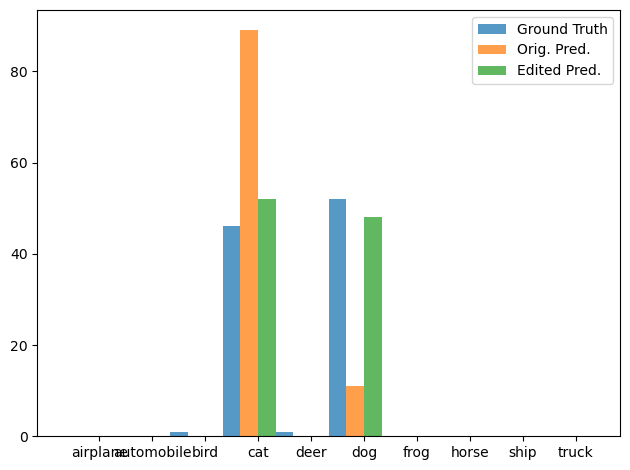

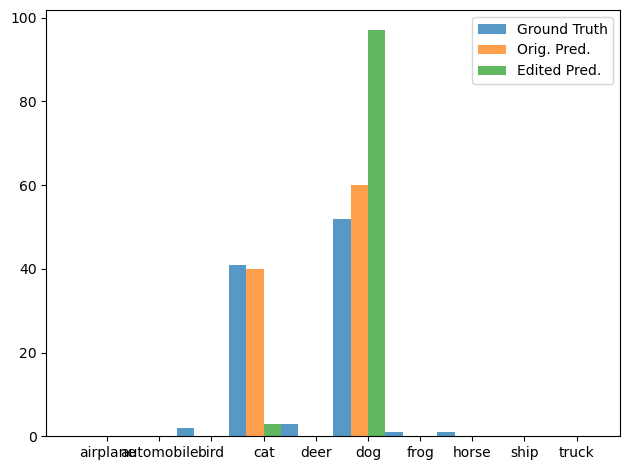

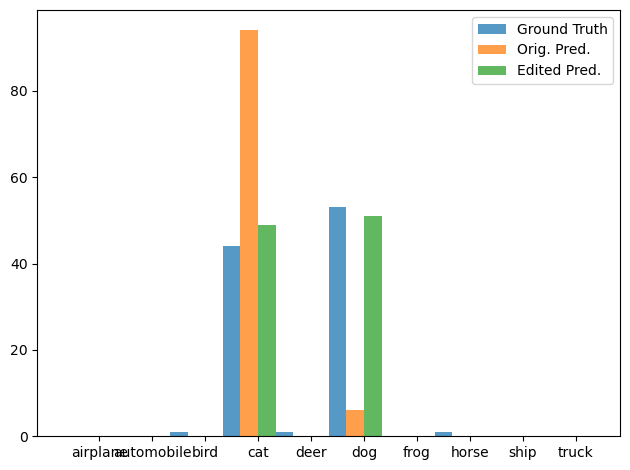

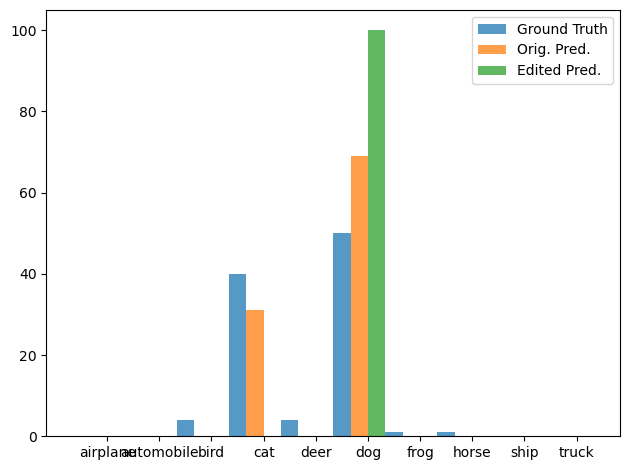

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4/models
Finished trial 24/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4
(0113_164431) Starting Trial 25/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/modi

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.56it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.07786932587623596 0.004029260948300362
L2 norm of weight change: 0.30398309230804443
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.12it/s]


Post-edit metrics: {'TP': array([6039, 5645, 5258, 2775, 4315, 3970, 5641, 5136, 4933, 4353]), 'TN': array([60581, 60590, 59298, 61703, 59988, 59894, 61102, 61785, 61449,
       61675]), 'FPs': array([2419, 2410, 3702, 1297, 3012, 3106, 1898, 1215, 1551, 1325]), 'FNs': array([ 961, 1355, 1742, 4225, 2685, 3030, 1359, 1864, 2067, 2647]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.95171429, 0.94621429, 0.92222857, 0.92111429, 0.91861429,
       0.91234286, 0.95347143, 0.95601429, 0.94831429, 0.94325714]), 'per_class_accuracy_mean': 0.9373285714285713, 'precision': array([0.71399858, 0.70080695, 0.58683036, 0.6814833 , 0.5889177 ,
       0.56105144, 0.74824247, 0.80869154, 0.76079581, 0.76664318]), 'precision_mean': 0.6917461340698016, 'recall': array([0.86271429, 0.80642857, 0.75114286, 0.39642857, 0.61642857,
       0.56714286, 0.80585714, 0.73371429, 0.70471429, 0.62185714]), 'recall_mean': 0.6866428571428571, 'f1': array([0.78134299, 0.74991697, 0.65889724, 0.50126

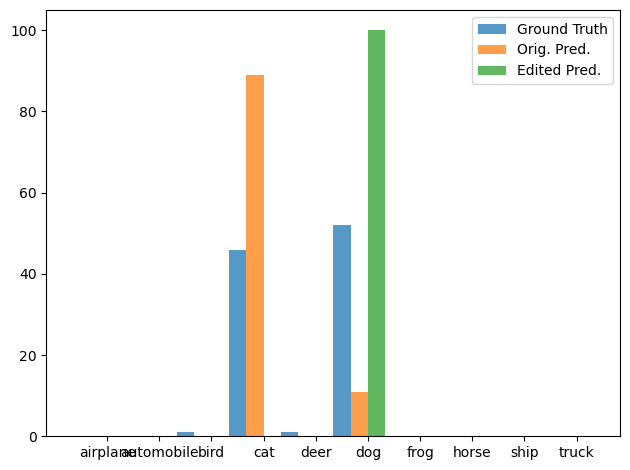

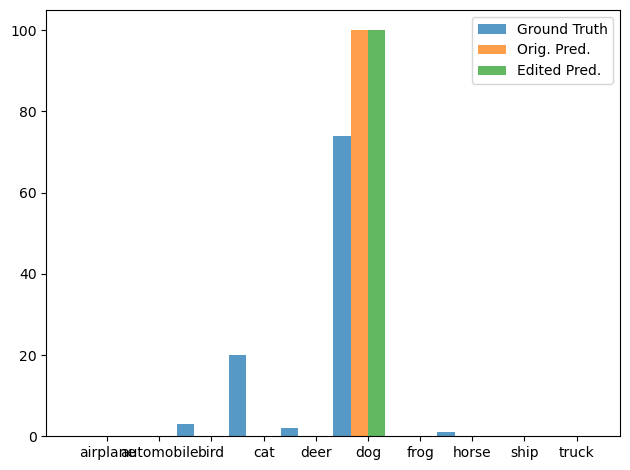

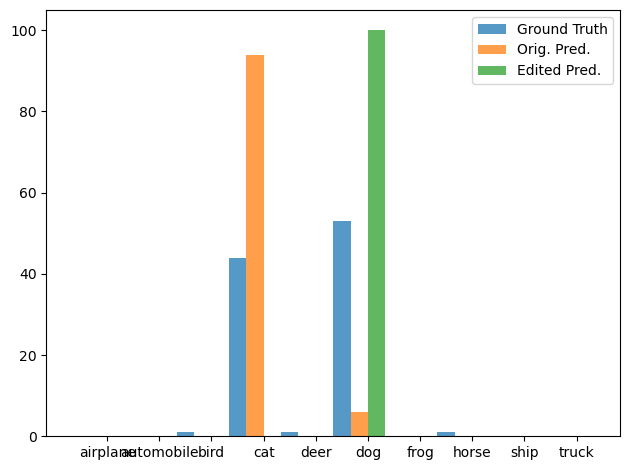

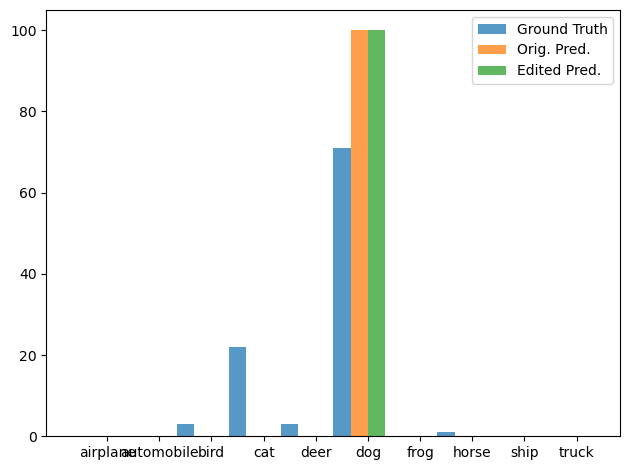

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0/models
Finished trial 25/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0
(0113_164601) Starting Trial 26/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/modified_i

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.09it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.10599926859140396 0.0038981973193585873
L2 norm of weight change: 0.4383980929851532
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.16it/s]


Post-edit metrics: {'TP': array([5938, 5774, 5266,    1, 4285, 4616, 5586, 5139, 4926, 4168]), 'TN': array([60910, 60218, 59244, 62992, 60097, 55861, 61258, 61786, 61460,
       61873]), 'FPs': array([2090, 2782, 3756,    8, 2903, 7139, 1742, 1214, 1540, 1127]), 'FNs': array([1062, 1226, 1734, 6999, 2715, 2384, 1414, 1861, 2074, 2832]), 'accuracy': 0.6528428571428572, 'per_class_accuracy': array([0.95497143, 0.94274286, 0.92157143, 0.8999    , 0.91974286,
       0.86395714, 0.95491429, 0.95607143, 0.94837143, 0.94344286]), 'per_class_accuracy_mean': 0.9305685714285715, 'precision': array([0.73966119, 0.67484806, 0.58368433, 0.11111111, 0.59613244,
       0.39268396, 0.76228166, 0.80890918, 0.76183112, 0.7871577 ]), 'precision_mean': 0.6218300739937929, 'recall': array([8.48285714e-01, 8.24857143e-01, 7.52285714e-01, 1.42857143e-04,
       6.12142857e-01, 6.59428571e-01, 7.98000000e-01, 7.34142857e-01,
       7.03714286e-01, 5.95428571e-01]), 'recall_mean': 0.6528428571428571, 'f1': arr

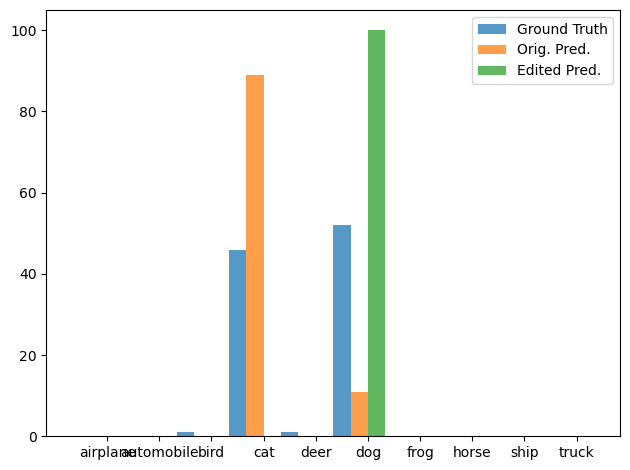

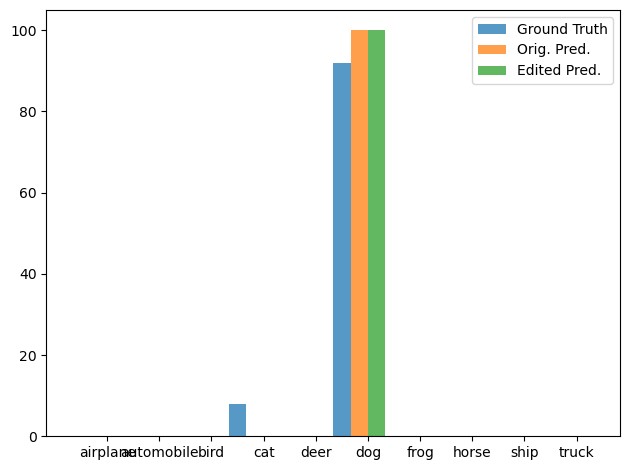

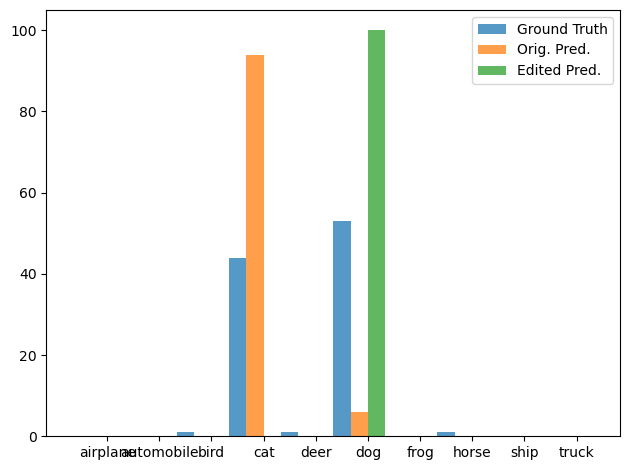

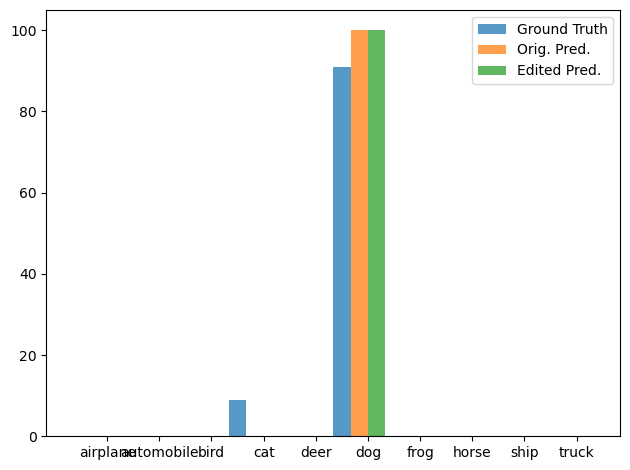

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2/models
Finished trial 26/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2
(0113_164727) Starting Trial 27/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/watershed_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.03it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:


Loss (orig, final): 0.078083835542202 0.004048333503305912
L2 norm of weight change: 0.30686041712760925
Performing post-edit metric & KNN calculations on validation set.


100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.65it/s]


Post-edit metrics: {'TP': array([6023, 5641, 5257, 2763, 4304, 4008, 5639, 5146, 4922, 4360]), 'TN': array([60665, 60597, 59308, 61703, 60023, 59777, 61103, 61768, 61458,
       61661]), 'FPs': array([2335, 2403, 3692, 1297, 2977, 3223, 1897, 1232, 1542, 1339]), 'FNs': array([ 977, 1359, 1743, 4237, 2696, 2992, 1361, 1854, 2078, 2640]), 'accuracy': 0.6866142857142857, 'per_class_accuracy': array([0.95268571, 0.94625714, 0.92235714, 0.92094286, 0.91895714,
       0.91121429, 0.95345714, 0.95591429, 0.94828571, 0.94315714]), 'per_class_accuracy_mean': 0.9373228571428571, 'precision': array([0.72062694, 0.70126803, 0.58743994, 0.68054187, 0.59112759,
       0.55428018, 0.74827495, 0.806836  , 0.76144802, 0.7650465 ]), 'precision_mean': 0.6916890019213197, 'recall': array([0.86042857, 0.80585714, 0.751     , 0.39471429, 0.61485714,
       0.57257143, 0.80557143, 0.73514286, 0.70314286, 0.62285714]), 'recall_mean': 0.6866142857142857, 'f1': array([0.78434692, 0.74993353, 0.65922628, 0.49963

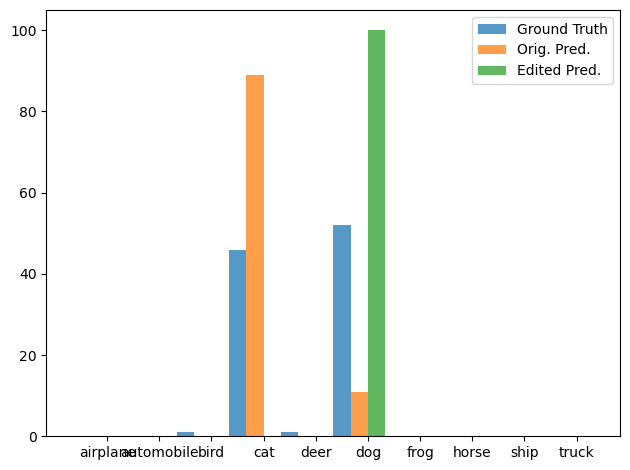

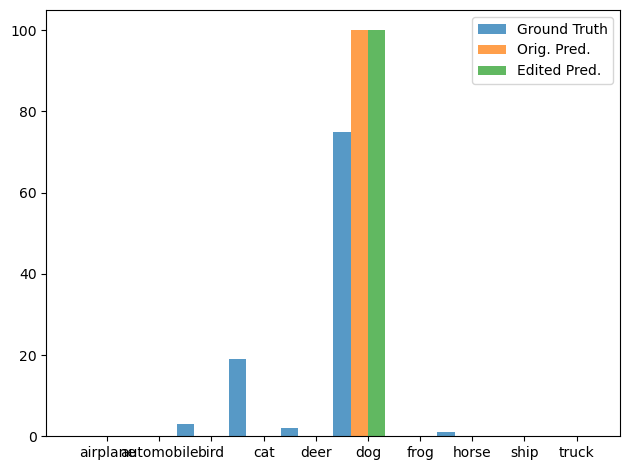

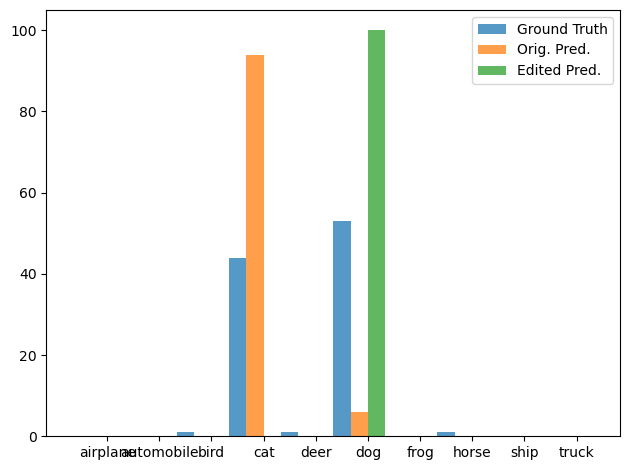

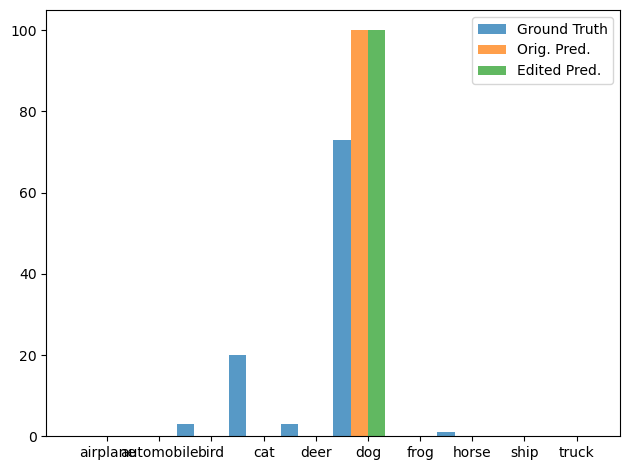

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0/models
Finished trial 27/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0
(0113_164851) Starting Trial 28/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/watershed_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.90it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>):  73%|▋| 29264/40000 [00:

In [ ]:
for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
    split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
    class_name = os.path.basename(os.path.dirname(key_path))
    file_name = os.path.basename(key_path).split(".")[0]
    key_image_id = "{}-{}-{}".format(class_name, split, file_name)
    # Print Progress
    informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)
    
    # Create run id 
    value_image_id = os.path.splitext(os.path.basename(value_path))[0]
    run_id = os.path.join(timestamp, key_image_id, value_image_id)
    informal_log("Current run_id: {}".format(run_id), progress_report_path)
    
    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    config_dict['editor'].update({
        'key_paths_file': key_path,
        'value_paths_file': value_path
    })
    
    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)
    
    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)
    
    informal_log("Calling edit()...", progress_report_path)
    
    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)
    
    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)


In [21]:
save_trials_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/trial_paths.txt'
trial_dirs = read_lists(save_trials_path)
knn_analysis_filename = 'knn_analysis_results.pth'

In [22]:
try:
    if not os.path.exists(save_trials_path):
        print("Path {} does not exist".format(save_trials_path))
    else:
        print("Obtaining trial paths from {}".format(save_trials_path))
except:
    print("Need to define save_trials_path.")



Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/trial_paths.txt


## Analyze KNN

In [23]:
## Process KNN results for each
n_trials = len(trial_dirs)
n_log = n_trials // 10 + 1  # log every 10%
progress_report_path = os.path.join(os.path.dirname(save_trials_path), 'progress_report_analysis.txt')

informal_log("Starting KNN analysis...", progress_report_path)
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # if trial_idx % n_log == 0:
    informal_log("Processing {}/{} trials. Currently processing {}".format(
        trial_idx+1, n_trials, os.path.basename(trial_dir)), progress_report_path)
                     
    results_save_dir = os.path.join(trial_dir, 'models')
    load_and_analyze_knn(
        restore_dir=results_save_dir,
        pre_edit_knn_path=os.path.join(results_save_dir, 'pre_edit_{}-nn.pth'.format(K)),
        post_edit_knn_path=os.path.join(results_save_dir, 'post_edit_{}-nn.pth'.format(K)),
        knn_analysis_filename=knn_analysis_filename,
        target_class_idx=target_class_idx,
        class_list=class_list,
        progress_report_path=progress_report_path,
        save_images=False,
        save_plots=True)
    


Starting KNN analysis...


0it [00:00, ?it/s]

Processing 1/37 trials. Currently processing felzenszwalb_gaussian_0
Analyzing KNN results from saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models
Logging and saving visualizations to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_visualizations/knn_analysis_log.txt
Saving results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_analysis_results.pth


0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/edited_model.pth'

## Convert to CSV for all trials

In [24]:
data = []
# Iterate through all trials
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # Obtain key ID from path
    key_id = os.path.basename(os.path.dirname(trial_dir))
    id_class = key_id.split('-')[0]
    if id_class not in class_list:
        raise ValueError("Invalid key_id {}".format(key_id))
    # Obtain value ID from path
    val_id = os.path.basename(trial_dir)
    # Join to make a data ID
    data_id = os.path.join(key_id, val_id)
    
    # Load results from knn, pre-edit metrics, and post-edit metrics
    restore_dir = os.path.join(trial_dir, 'models')
    knn_analysis_results = torch.load(os.path.join(restore_dir, knn_analysis_filename))
    pre_edit_metrics = torch.load(os.path.join(restore_dir, 'pre_edit_metrics.pth'))
    post_edit_metrics = torch.load(os.path.join(restore_dir, 'post_edit_metrics.pth'))
    
    # Combine results into one dictionary
    combined_results = combine_results(
        data_id=data_id,
        knn_analysis=knn_analysis_results,
        pre_edit_metrics=pre_edit_metrics,
        post_edit_metrics=post_edit_metrics)
    
    # Save column headers in first trial run
    if trial_idx == 0:
        column_headers = list(combined_results.keys())
    # Convert results to np.array & append to list
    combined_results = np.expand_dims(np.array(list(combined_results.values())), axis=0)
    data.append(combined_results)

# Convert data from list of np.arrays -> pd.DataFrame    
data = np.concatenate(data, axis=0)
df = pd.DataFrame(data, columns=column_headers)


37it [00:01, 23.99it/s]


In [25]:
# Save to CSV
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
df.to_csv(csv_save_path)
print("Saved CSV to {}".format(csv_save_path))

Saved CSV to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/results_table.csv
